# Goal
- Analyze the bias variance tradeoff of the dataset
- We adopt the setting from Cuarana 2009

In [1]:
import os
os.chdir('../')

import sys
sys.path.insert(0, './my_interpret/python')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import loaddata_utils
import pickle
from general_utils import vector_in
from vis_utils import vis_main_effects

# interpret.set_show_addr(("127.0.0.1", 7001))

In [4]:
random_state = 1377

## Load all the dataframes for qualitative purposes

In [5]:
all_record_df = pd.read_csv('./results/091719_datasets.csv')
all_record_df.tail()

d_name               model_name  split_idx  n_splits  random_state  \
2926  mimiciii  xgb-d1-o100-cols0.00001          4         5          1377   
2927    credit  xgb-d1-o100-cols0.00001          1         5          1377   
2928    credit  xgb-d1-o100-cols0.00001          2         5          1377   
2929    credit  xgb-d1-o100-cols0.00001          3         5          1377   
2930    credit  xgb-d1-o100-cols0.00001          4         5          1377   

         fit_time  test_size  test_auc  test_aupr  test_mse  test_acc  \
2926   198.441348       0.15  0.816942   0.409928  0.072529  0.906166   
2927  3358.916798       0.15  0.981204   0.843761  0.000433  0.999532   
2928  3119.467676       0.15  0.986969   0.835081  0.000504  0.999391   
2929  3011.085643       0.15  0.973703   0.840544  0.000460  0.999438   
2930  3177.965137       0.15  0.981466   0.879829  0.000369  0.999625   

      test_logloss  train_auc  train_aupr  train_mse  train_acc  \
2926      0.253672   0.847569    0.449038   0.069781   0.910432   
2927      0.002812   0.999014    0.923041   0.000316   0.999636   
2928      0.002902   0.998671    0.922174   0.000322   0.999636   
2929      0.002962   0.998571    0.923910   0.000323   0.999628   
2930      0.002319   0.998854    0.917411   0.000329   0.999616   

      train_logloss                                         model_path  
2926       0.241637  models/091719_datasets/mimiciii_xgb-d1-o100-co...  
2927       0.001575  models/091719_datasets/credit_xgb-d1-o100-cols...  
2928       0.001600  models/091719_datasets/credit_xgb-d1-o100-cols...  
2929       0.001602  models/091719_datasets/credit_xgb-d1-o100-cols...  
2930       0.001648  models/091719_datasets/credit_xgb-d1-o100-cols...

## Only filter the top 5 splits!

In [6]:
all_record_df = all_record_df[all_record_df.split_idx.apply(lambda x: int(x) < 5)]
all_record_df.tail()

d_name               model_name  split_idx  n_splits  random_state  \
2926  mimiciii  xgb-d1-o100-cols0.00001          4         5          1377   
2927    credit  xgb-d1-o100-cols0.00001          1         5          1377   
2928    credit  xgb-d1-o100-cols0.00001          2         5          1377   
2929    credit  xgb-d1-o100-cols0.00001          3         5          1377   
2930    credit  xgb-d1-o100-cols0.00001          4         5          1377   

         fit_time  test_size  test_auc  test_aupr  test_mse  test_acc  \
2926   198.441348       0.15  0.816942   0.409928  0.072529  0.906166   
2927  3358.916798       0.15  0.981204   0.843761  0.000433  0.999532   
2928  3119.467676       0.15  0.986969   0.835081  0.000504  0.999391   
2929  3011.085643       0.15  0.973703   0.840544  0.000460  0.999438   
2930  3177.965137       0.15  0.981466   0.879829  0.000369  0.999625   

      test_logloss  train_auc  train_aupr  train_mse  train_acc  \
2926      0.253672   0.847569    0.449038   0.069781   0.910432   
2927      0.002812   0.999014    0.923041   0.000316   0.999636   
2928      0.002902   0.998671    0.922174   0.000322   0.999636   
2929      0.002962   0.998571    0.923910   0.000323   0.999628   
2930      0.002319   0.998854    0.917411   0.000329   0.999616   

      train_logloss                                         model_path  
2926       0.241637  models/091719_datasets/mimiciii_xgb-d1-o100-co...  
2927       0.001575  models/091719_datasets/credit_xgb-d1-o100-cols...  
2928       0.001600  models/091719_datasets/credit_xgb-d1-o100-cols...  
2929       0.001602  models/091719_datasets/credit_xgb-d1-o100-cols...  
2930       0.001648  models/091719_datasets/credit_xgb-d1-o100-cols...

## Check

In [7]:
all_record_df.model_name.unique()

array(['xgb-d3-o20', 'xgb-d1-o20', 'lr', 'spline', 'rf-n1000', 'mlr',
       'ilr', 'xgb-d3', 'skgbt-d3', 'skgbt-d3-o20', 'flam',
       'skgbt-d1-o20', 'xgb-d1-o20-cv', 'skgbt-d1-o20-cv', 'ebm-o50-i50',
       'ebm-bf-o50', 'ebm-bf-o50-i50', 'mlr-o20', 'ilr-o20', 'spline-cv',
       'spline-v2', 'xgb-d3-o20-cv', 'ebm-o50-i50-cv', 'ebm-bf-o50-cv',
       'skgbt-d3-cv', 'ebm-o50-cv', 'skgbt-d3-o20-cv', 'ebm-bf-o50-q',
       'ilr-q', 'ebm-o50-i50-q', 'mlr-q', 'spline-b', 'rspline-v2',
       'xgb-d1-o20-cols1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols0.1',
       'xgb-d1-o20-cols0.75', 'xgb-d1-o20-cols0.25',
       'xgb-d1-o20-cols0.00001', 'lr-l1', 'rspline-v2-s',
       'ebm-h-bf-o50-q', 'ebm-h-o50-i50-q', 'xgb-l-d1-o20-cols0.5',
       'xgb-l-d3-cols0.5', 'xgb-l-d3-o20-cols0.5', 'xgb-l-d1-o20-cols1',
       'xgb-d1', 'xgb-l-d1-o20-cols0.00001', 'ebm-o100-i100-q',
       'ebm-bf-o100-i100-q', 'xgb-d1-o100', 'xgb-d1-o100-cols0.00001'],
      dtype=object)

In [8]:
all_record_df.d_name.unique()

array(['adult', 'bikeshare', 'breast', 'calhousing', 'churn', 'mimiciii',
       'pneumonia', 'heart', 'credit', 'onlinenews', 'mimicii', 'wine',
       'support2cls2', 'diabetes2', 'compass', 'support2reg2'],
      dtype=object)

In [9]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
all_record_df.groupby(['d_name', 'model_name']).apply(lambda x: len(x))

d_name        model_name              
adult         ebm-bf-o100-i100-q          5
              ebm-bf-o50-q                5
              ebm-h-bf-o50-q              5
              ebm-h-o50-i50-q             5
              ebm-o100-i100-q             5
              ebm-o50-i50-q               5
              flam                        5
              ilr-q                       5
              lr                          5
              lr-l1                       5
              mlr-q                       5
              rf-n1000                    5
              rspline-v2                  5
              rspline-v2-s                5
              spline                      5
              spline-b                    5
              spline-v2                   5
              xgb-d1                      5
              xgb-d1-o100                 5
              xgb-d1-o100-cols0.00001     5
              xgb-d1-o20                  5
              xgb-d1-o20-cols0.00001 

## All Performance

### Calculate the rank for each record

In [10]:
lookup = all_record_df.groupby(['d_name', 'split_idx']).apply(lambda x: pd.Series(x.test_auc.rank(ascending=False).values, index=x.model_name.values))
lookup = lookup.sort_index()

all_record_df['test_auc_rank'] = all_record_df.apply(lambda x: lookup.loc[x.d_name, x.split_idx, x.model_name], axis=1)

In [11]:
def cal_normalized_score(metrics, baseline='lowest', is_higher_better=True):
    ''' Take the best and the worst to normalize between 0 to 1 '''
    the_lowest = np.min(metrics) if baseline == 'lowest' else baseline
    score = (metrics - the_lowest) / (np.max(metrics) - the_lowest)
    if not is_higher_better:
        score = 1. - score
    return score
    
lookup = all_record_df.groupby(['d_name', 'split_idx']).apply(lambda x: pd.Series(cal_normalized_score(x.test_auc).values, index=x.model_name.values))
lookup = lookup.sort_index()

all_record_df['test_auc_score'] = all_record_df.apply(lambda x: lookup.loc[x.d_name, x.split_idx, x.model_name], axis=1)

In [12]:
lookup = all_record_df.groupby(['d_name', 'split_idx']).apply(lambda x: pd.Series(cal_normalized_score(x.test_auc, baseline=0.5).values, index=x.model_name.values))
lookup = lookup.sort_index()

all_record_df['test_auc_score_b0.5'] = all_record_df.apply(lambda x: lookup.loc[x.d_name, x.split_idx, x.model_name], axis=1)

### Classification

In [13]:
all_record_df = all_record_df.sort_values('model_name')

In [14]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg', 'wine'])]
# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']
# cls_record_df = cls_record_df[cls_record_df.d_name != 'credit']

# for metric in ['test_auc', 'test_auc_rank', 'test_auc_score', 'test_auc_score_b0.5', 'test_mse', 'test_aupr']:
for metric in ['test_auc', 'test_mse', 'test_aupr']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['test_auc', 'test_auc_score', 'test_auc_score_b0.5', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean(), axis=0)
    new_table = add_new_row(table, mean_score.apply(lambda x: '%.4f' % x), 'average')
    
    average_rank = mean_score.rank(ascending=(not is_metric_higher_better))
    new_table = add_new_row(new_table, average_rank, 'average_rank')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')
    
    if 'auc' in metric:
        mean_normalized_score_b = table.apply(normalized_score, axis=1, min_value=0.5, is_metric_higher_better=is_metric_higher_better).mean()
        new_table = add_new_row(new_table, mean_normalized_score_b.apply(lambda x: '%.3f' % x), 'avg_score_b0.5')

        avg_score_rank_b = mean_normalized_score_b.rank(ascending=False)
        new_table = add_new_row(new_table, avg_score_rank_b, 'avg_score_b0.5_rank')
    
    display(new_table.style.apply(highlight_min_max, axis=1))

test_auc


test_mse


test_aupr


#### Figure

In [ ]:
import seaborn as sns

for d_name, df in cls_record_df.groupby('d_name'):
#     fig, axes = plt.subplots(2, 3, figsize=(35, 20))
    fig, axes = plt.subplots(1, 3, figsize=(35, 10))

    sns.barplot(data=df, x='model_name', y='test_auc', ax=axes.flat[0])    
    sns.barplot(data=df, x='model_name', y='test_mse', ax=axes.flat[1])
    sns.barplot(data=df, x='model_name', y='test_aupr', ax=axes.flat[2])

#     sns.barplot(data=df, x='model_name', y='train_auc', ax=axes.flat[3])    
#     sns.barplot(data=df, x='model_name', y='train_mse', ax=axes.flat[4])
#     sns.barplot(data=df, x='model_name', y='train_aupr', ax=axes.flat[5])
    
    fig.suptitle(d_name, fontsize=30)

    for ax in axes.flat:
        ax.xaxis.set_tick_params(rotation=45)
    plt.show()

### Regression

In [ ]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

reg_record_df = all_record_df[vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg', 'wine'])]

for metric in ['test_mse']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    tmp = reg_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f +- %.5f' % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['test_auc', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean(), axis=0)
    new_table = add_new_row(table, mean_score, 'average')
    
    mean_score_rank = table.apply(lambda x: '%.3f' % (x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean()), axis=0)
    new_table = add_new_row(table, mean_score, 'average')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean().apply(lambda x: '%.2f' % x)
    new_table = add_new_row(new_table, mean_rank, 'avg_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean().apply(lambda x: '%.3f' % x)
    new_table = add_new_row(new_table, mean_normalized_score, 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')

    display(new_table.style.apply(highlight_min_max, axis=1))

In [ ]:
import seaborn as sns

for d_name, df in reg_record_df.groupby('d_name'):
#     fig, axes = plt.subplots(2, 3, figsize=(35, 20))
    fig, axes = plt.subplots(1, 3, figsize=(35, 10))

#     sns.barplot(data=df, x='model_name', y='test_auc', ax=axes.flat[0]) 
    sns.barplot(data=df, x='model_name', y='test_mse', ax=axes.flat[1])
#     sns.barplot(data=df, x='model_name', y='test_aupr', ax=axes.flat[2])

#     sns.barplot(data=df, x='model_name', y='train_auc', ax=axes.flat[3])    
#     sns.barplot(data=df, x='model_name', y='train_mse', ax=axes.flat[4])
#     sns.barplot(data=df, x='model_name', y='train_aupr', ax=axes.flat[5])
    
    fig.suptitle(d_name, fontsize=30)

    for ax in axes.flat:
        ax.xaxis.set_tick_params(rotation=45)
    plt.show()

## Refined Performance
1. Figure out if cv actually has effect on the EBM. Run ebm-bf-o50-cv and ebm-o50-i50-cv on more datasets. Also run ebm-bf-o50-i50 on all datasets.
2. Run xgb-d1-o20 xgb-d3 on the mimicii, support2cls. Run xgb-d3-o20-cv on breast, heart, churn, mimiciii, pneumonia
3. Spline-v2 wins spline
4. (Less important): skgbt => skgbt-d3-cv v.s. skgbt-d3-o20-cv on adult, breast, churn, heart, pneumonia, mimicii, mimiciii

In [119]:
all_record_df = all_record_df.sort_values('model_name')

### Classification

Impute XGB-l

In [208]:
all_tables['test_auc']['xgb-l-d1-o20-cols0.5'] = all_tables['test_auc']

In [213]:
all_tables['test_auc']

ebm-bf-o50-q ebm-o50-i50-q     flam    ilr-q       lr  \
adult                    0.00566       0.00521  0.00630  0.00548  0.00622   
breast                   0.00474       0.00471  0.00309  0.00534  0.00421   
churn                    0.00836       0.00747  0.00720  0.00986  0.00741   
compass                  0.01590       0.01372  0.01682  0.01283  0.01012   
credit                   0.00898       0.00503  0.00411  0.00590  0.01075   
diabetes2                0.00568       0.00449  0.00629  0.00654  0.00549   
heart                    0.06831       0.06828  0.06677  0.06337  0.05782   
mimicii                  0.00897       0.00920  0.01008  0.01033  0.00805   
mimiciii                 0.00550       0.00373  0.00445  0.01034  0.00495   
pneumonia                0.00839       0.00637  0.00901  0.01037  0.00575   
support2cls2             0.01043       0.01006  0.01097  0.01154  0.00667   
average                   0.0137        0.0126   0.0132   0.0138   0.0116   
average_rank                   4             9        7        2       12   
avg_rank                    4.64          7.27     5.09     4.18     7.73   
avg_rank_rank                  2             8        3        1        9   
avg_score                  0.578         0.390    0.572    0.677    0.342   
avg_score_rank                 3            11        4        2       12   
avg_score_b0.5             1.006         1.008    1.007    1.006    1.010   
avg_score_b0.5_rank           10             5        8       11        2   

                       mlr-q rf-n1000 spline-v2   xgb-d3 xgb-d3-o20  \
adult                0.00400  0.00517   0.00625  0.00571    0.00498   
breast               0.00526  0.01089   0.00799  0.01064    0.00659   
churn                0.01043  0.00597   0.00759  0.00658    0.00624   
compass              0.01288  0.01175   0.01517      NaN        NaN   
credit               0.01403  0.01548   0.00693  0.00682    0.00438   
diabetes2            0.00700  0.00548       NaN      NaN        NaN   
heart                0.05270  0.06508   0.06325  0.04554    0.05659   
mimicii              0.00684  0.00574   0.00824  0.00720    0.01152   
mimiciii             0.00280  0.00787   0.00426  0.00739    0.00691   
pneumonia            0.00669  0.00461   0.00608  0.00832    0.01268   
support2cls2         0.00897  0.01047   0.01083      NaN        NaN   
average               0.0120   0.0135    0.0137   0.0123     0.0137   
average_rank              11        6         5       10          3   
avg_rank                7.00     6.82      5.82     7.91       7.82   
avg_rank_rank              7        6         5       11         10   
avg_score              0.435    0.494     0.539    0.426      0.497   
avg_score_rank             9        8         5       10          7   
avg_score_b0.5         1.010    1.006     1.008    1.013      1.010   
avg_score_b0.5_rank        4        9         6        1          3   

                    xgb-l-d1-o20-cols0.5  
adult                            0.00617  
breast                           0.00466  
churn                            0.00742  
compass                          0.01440  
credit                           0.00619  
diabetes2                        0.00578  
heart                            0.06900  
mimicii                          0.00969  
mimiciii                         0.00551  
pneumonia                        0.00745  
support2cls2                     0.01020  
average                           0.0188  
average_rank                           1  
avg_rank                            8.00  
avg_rank_rank                         12  
avg_score                          0.691  
avg_score_rank                         1  
avg_score_b0.5                     1.003  
avg_score_b0.5_rank                   12

#### Encoding

In [277]:
for metric in all_tables:
    all_tables[metric].to_csv('notebooks/figures/encoding_%s.csv' % metric)

In [346]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max, cal_statistics

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg2', 'wine', 'breast', 'credit', 'mimicii', 'mimiciii', 'pneumonia'])]
# cls_record_df = cls_record_df[vector_in(cls_record_df.d_name, ['mimicii', 'compass'])]
# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']
cls_record_df = cls_record_df[
    vector_in(all_record_df.model_name, 
        [
            'ebm-o50-i50-q', 'ebm-h-o50-i50-q', 'ebm-bf-o50-q', 'ebm-h-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'xgb-d1-o20-cols0.5'
        ]
    )]

cls_record_df = cls_record_df.sort_values('model_name')

all_tables = {}
for metric in ['test_auc', 'test_auc_rank', 'test_auc_score', 'test_auc_score_b0.5', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
#     tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
#     tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f' % (x['mean']), axis=1)
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f' % (x['mean']), axis=1)

    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    #### Copy the performance from the one-hot
    table['xgb-l-d1-o20-cols0.5'] = table.apply(lambda row: row['xgb-d1-o20-cols0.5'] if pd.isna(row['xgb-l-d1-o20-cols0.5']) else row['xgb-l-d1-o20-cols0.5'], axis=1)
    table['ebm-h-bf-o50-q'] = table.apply(lambda row: row['ebm-bf-o50-q'] if pd.isna(row['ebm-h-bf-o50-q']) else row['ebm-h-bf-o50-q'], axis=1)
    table['ebm-h-o50-i50-q'] = table.apply(lambda row: row['ebm-o50-i50-q'] if pd.isna(row['ebm-h-o50-i50-q']) else row['ebm-h-o50-i50-q'], axis=1)


#     #### Reshuffle the xgb-d1-o20-cols1 to the last column
#     tmp5 = table['xgb-d1-o20-cols1'].copy()
#     table = table.drop(['xgb-d1-o20-cols1'], axis=1)
#     table['xgb-d1-o20-cols1'] = tmp5
    
    is_metric_higher_better = (metric in ['test_auc', 'test_auc_score', 'test_auc_score_b0.5', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    new_table = cal_statistics(table, is_metric_higher_better, add_ns_baseline=False)
    
    all_tables[metric] = new_table
    display(new_table.style.apply(highlight_min_max, axis=1))

    # "ebm-bf-o50", "ebm-o50-i50" "skgbt-d1-o20-cv" "xgb-d1-o20-cv"

/home/intelligible/miniconda3/envs/kingsley/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


test_auc


test_auc_rank


test_auc_score


test_auc_score_b0.5


test_mse


test_aupr


test_logloss


test_acc


In [365]:
for metric in all_tables:
#     all_tables[metric].to_csv('notebooks/figures/real_data_refined_%s_mean.csv' % metric)
    all_tables[metric].to_csv('notebooks/figures/real_data_refined_%s_std.csv' % metric)    

#### Candidates comparisons

In [18]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max, cal_statistics

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg2', 'wine', 'diabetes2'])]
# cls_record_df = cls_record_df[vector_in(cls_record_df.d_name, ['mimicii', 'compass'])]
# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']
cls_record_df = cls_record_df[
    vector_in(all_record_df.model_name, 
        [
#             'ebm-o50-i50', 'ebm-bf-o50', 'ebm-bf-o50-i50', 'ebm-o30-i30', 'ebm-bf-o30', 'ebm-bf-o30-i30', 'ebm-o50-i50-cv', 'ebm-bf-o50-cv',
#          'xgb-d1-o20', 'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20', 'xgb-d3-o20-cv',
#          'rf-n1000', 'mlr', 'lr', 'ilr', 'flam',
#          'spline', 'spline-v2',
#          'skgbt-d1-o20', 'skgbt-d1-o20-cv-v2', 'skgbt-d1-o20-cv', 'skgbt-d1-o20-cv-v2', 'skgbt-d3', 'skgbt-d3-o20', 'skgbt-d3-cv', 'skgbt-d3-o20-cv', 
#             'ebm-o50-i50', 'ebm-o50-i50-q', 'ebm-bf-o50', 'ebm-bf-o50-q', 'ilr', 'ilr-q', 'mlr', 'mlr-q', 'xgb-d1-o20-cv',
#             'spline-b', 'spline-v2', 'rspline-v2'
#            'xgb-d1-o20-cv', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1',
#            'lr', 'lr-l1',
#            'xgb-l-d1-o20-cols0.00001', 'xgb-l-d1-o20-cols0.1', 'xgb-l-d1-o20-cols0.5', 'xgb-l-d1-o20-cols1',
#            'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1',
#             'xgb-d1-o20-cv', 
            'ebm-o100-i100-q', 'ebm-bf-o100-i100-q',
#             'xgb-d3', 'xgb-d3-o20',
#             'xgb-d1', 
            'xgb-d1-o100', 
            'xgb-d1-o20-cols0.00001',
#             'xgb-l-d1-o20-cols1',
            'xgb-d3',
            'flam',
            'spline-v2',
            'lr', 'mlr-q', 'ilr-q', 'rf-n1000', 
#             'skgbt-d1-o20-cv', 'skgbt-d3-cv',
        ]
    )]

all_tables = {}
for metric in ['test_auc', 'test_auc_rank', 'test_auc_score', 'test_auc_score_b0.5', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
#     tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
#     tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f' % (x['mean']), axis=1)
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std'])\
        .apply(lambda x: '%.5f' % (x['std']), axis=1)

    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    #### Copy the performance from the one-hot
    if 'xgb-l-d1-o20-cols1' in table:
        table['xgb-l-d1-o20-cols1'] = table.apply(lambda row: row['xgb-d1-o20-cols1'] if pd.isna(row['xgb-l-d1-o20-cols1']) else row['xgb-l-d1-o20-cols1'], axis=1)
#     #### Reshuffle the xgb-d1-o20-cols1 to the last column
#     tmp5 = table['xgb-d1-o20-cols1'].copy()
#     table = table.drop(['xgb-d1-o20-cols1'], axis=1)
#     table['xgb-d1-o20-cols1'] = tmp5
    
    is_metric_higher_better = (metric in ['test_auc', 'test_auc_score', 'test_auc_score_b0.5', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    new_table = cal_statistics(table, is_metric_higher_better, add_ns_baseline=False)
    
    all_tables[metric] = new_table
    display(new_table.style.apply(highlight_min_max, axis=1))

    # "ebm-bf-o50", "ebm-o50-i50" "skgbt-d1-o20-cv" "xgb-d1-o20-cv"

test_auc


/h/kingsley/anaconda3/envs/gam/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


test_auc_rank


test_auc_score


test_auc_score_b0.5


test_mse


test_aupr


test_logloss


test_acc


In [19]:
# for metric in all_tables:
#     all_tables[metric].to_csv('notebooks/figures/real_%s.csv' % metric)

for metric in all_tables:
#     all_tables[metric].to_csv('notebooks/figures/final_real_all_%s.csv' % metric)
    all_tables[metric].to_csv('notebooks/figures/final_real_all_%s_std.csv' % metric)

In [176]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg', 'wine'])]
# cls_record_df = cls_record_df[~vector_in(cls_record_df.d_name, ['heart', 'diabetes', 'credit'])]
# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']
cls_record_df = cls_record_df[
    vector_in(all_record_df.model_name, 
        [
#             'ebm-o50-i50', 'ebm-bf-o50', 'ebm-bf-o50-i50', 'ebm-o30-i30', 'ebm-bf-o30', 'ebm-bf-o30-i30', 'ebm-o50-i50-cv', 'ebm-bf-o50-cv',
#          'xgb-d1-o20', 'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20', 'xgb-d3-o20-cv',
#          'rf-n1000', 'mlr', 'lr', 'ilr', 'flam',
#          'spline', 'spline-v2',
#          'skgbt-d1-o20', 'skgbt-d1-o20-cv-v2', 'skgbt-d1-o20-cv', 'skgbt-d1-o20-cv-v2', 'skgbt-d3', 'skgbt-d3-o20', 'skgbt-d3-cv', 'skgbt-d3-o20-cv', 
#             'ebm-o50-i50', 'ebm-o50-i50-q', 'ebm-bf-o50', 'ebm-bf-o50-q', 'ilr', 'ilr-q', 'mlr', 'mlr-q', 'xgb-d1-o20-cv',
#             'spline-b', 'spline-v2', 'rspline-v2'
#            'xgb-d1-o20-cv', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1',
#            'lr', 'lr-l1',

            'ebm-o50-i50-q', 'ebm-bf-o50-q',
            'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20',
            'flam',
            'rspline-v2', 'spline-v2',
            'lr', 'mlr-q', 'ilr-q', 'rf-n1000', 
            'skgbt-d1-o20-cv', 'skgbt-d3-cv',
        ]
    )]

for metric in ['test_auc', 'test_auc_rank', 'test_auc_score', 'test_auc_score_b0.5', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['test_auc', 'test_auc_score', 'test_auc_score_b0.5', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean(), axis=0)
    new_table = add_new_row(table, mean_score.apply(lambda x: '%.4f' % x), 'average')
    
    average_rank = mean_score.rank(ascending=(not is_metric_higher_better))
    new_table = add_new_row(new_table, average_rank, 'average_rank')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')
    
    if 'auc' in metric:
        mean_normalized_score_b = table.apply(normalized_score, axis=1, min_value=0.5, is_metric_higher_better=is_metric_higher_better).mean()
        new_table = add_new_row(new_table, mean_normalized_score_b.apply(lambda x: '%.3f' % x), 'avg_score_b0.5')

        avg_score_rank_b = mean_normalized_score_b.rank(ascending=False)
        new_table = add_new_row(new_table, avg_score_rank_b, 'avg_score_b0.5_rank')
    
    display(new_table.style.apply(highlight_min_max, axis=1))

    # "ebm-bf-o50", "ebm-o50-i50" "skgbt-d1-o20-cv" "xgb-d1-o20-cv"

/home/intelligible/miniconda3/envs/kingsley/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


test_auc


test_auc_rank


test_auc_score


test_auc_score_b0.5


test_mse


test_aupr


test_logloss


test_acc


### Regression
- EBM: ebm-o50-i50-cv ebm-o50-cv: bikeshare calhousing onlinenews support2reg
- SKGBT: skgbt-d3-cv skgbt-d3-o20-cv: bikeshare calhousing onlinenews support2reg wine

In [ ]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max

reg_record_df = all_record_df[vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'support2reg', 'wine'])]
reg_record_df = reg_record_df[
    vector_in(all_record_df.model_name, 
        [
#             'ebm-o50-i50', 'ebm-bf-o50', 'ebm-bf-o50-i50', 'ebm-o30-i30', 'ebm-bf-o30', 'ebm-bf-o30-i30', 'ebm-o50-i50-cv', 'ebm-bf-o50-cv',
#          'xgb-d1-o20', 'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20', 'xgb-d3-o20-cv',
#          'rf-n1000', 'mlr', 'lr', 'ilr', 'flam',
#          'spline', 'spline-v2',
#          'skgbt-d1-o20', 'skgbt-d1-o20-cv-v2', 'skgbt-d1-o20-cv', 'skgbt-d1-o20-cv-v2', 'skgbt-d3', 'skgbt-d3-o20', 'skgbt-d3-cv', 'skgbt-d3-o20-cv', 
#             'ebm-o50-i50', 'ebm-bf-o50',
#             'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20',
#             'flam',
#             'spline-v2',
#             'lr', 'mlr', 'ilr', 'rf-n1000', 
#             'skgbt-d1-o20-cv', 'skgbt-d3-o20-cv',
#             'ebm-o50-i50', 'ebm-o50-i50-q', 'ebm-bf-o50', 'ebm-bf-o50-q', 'ilr', 'ilr-q', 'mlr', 'mlr-q', 'xgb-d1-o20-cv',
            'spline-b', 'spline-v2',

        ]
    )]
reg_record_df = reg_record_df.sort_values('model_name')

for metric in ['test_mse']:
# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    tmp = reg_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: '%.5f +- %.5f' % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['test_auc', 'test_aupr', 'test_acc', 'train_auc', 'train_aupr', 'train_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean(), axis=0)
    new_table = add_new_row(table, mean_score, 'average')
    
    average_rank = mean_score.rank(ascending=(not is_metric_higher_better))
    new_table = add_new_row(new_table, average_rank, 'average_rank')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')

    display(new_table.style.apply(highlight_min_max, axis=1))

In [ ]:
import seaborn as sns

for d_name, df in reg_record_df.groupby('d_name'):
#     fig, axes = plt.subplots(2, 3, figsize=(35, 20))
    fig, axes = plt.subplots(1, 3, figsize=(35, 10))

#     sns.barplot(data=df, x='model_name', y='test_auc', ax=axes.flat[0]) 
    sns.barplot(data=df, x='model_name', y='test_mse', ax=axes.flat[1])
#     sns.barplot(data=df, x='model_name', y='test_aupr', ax=axes.flat[2])

#     sns.barplot(data=df, x='model_name', y='train_auc', ax=axes.flat[3])    
#     sns.barplot(data=df, x='model_name', y='train_mse', ax=axes.flat[4])
#     sns.barplot(data=df, x='model_name', y='train_aupr', ax=axes.flat[5])
    
    fig.suptitle(d_name, fontsize=30)

    for ax in axes.flat:
        ax.xaxis.set_tick_params(rotation=45)
    plt.show()

## Load all the dfs

In [120]:
import os
all_dfs = {}

# for d_name in all_record_df.d_name.unique():
for d_name in ['pneumonia', 'mimiciii', 'mimicii', 'compass', 'support2cls2', 'heart', 'churn', 'adult', 'breast']:
#     if d_name == 'credit':
#         continue
    
    path = 'results/0927-091719_datasets-df/%s.pkl' % d_name
    if os.path.exists(path):
        print(d_name)
        all_dfs[d_name] = pickle.load(open(path, 'rb'))

pneumonia
mimiciii
mimicii
compass
support2cls2
heart
churn
adult
breast


In [ ]:
# from general_utils import Timer

# all_dfs = {}
# for d_name, df2 in all_record_df.groupby('d_name'):
#     with Timer(d_name, remove_start_msg=False):
#         if d_name not in all_dfs:
#             all_dfs[d_name] = {}

#         for model_name, df in df2.groupby('model_name'):
#             model = pickle.load(open(df.model_path.iloc[0], 'rb'))
#             if not hasattr(model, 'is_visualizable') or not model.is_visualizable:
#                 print(model_name, 'is not visualiable. Skip!')
#                 continue
#             with Timer(d_name + ' ' + model_name):
#                 models = df.model_path.apply(lambda x: pickle.load(open(x, 'rb')))
#                 all_dfs[d_name][model_name] = get_GAM_plot_dataframe_by_models(models.tolist())

## Binary plots

In [ ]:
all_binary_diffs = {}

for d_name in all_dfs:
    # Plot baseline models
    for model_name in all_dfs[d_name]:
        if model_name not in all_dfs[d_name]:
            print('%s %s does not have visualization or does not exist. Skip.' % (d_name, model_name))
            continue
        
        the_df = all_dfs[d_name][model_name]
        the_df = the_df[the_df.x.apply(lambda x: x is not None and len(x) == 2)]
        model_diff = the_df.y.apply(lambda y: y[1] - y[0])
        if len(model_diff) == 0:
            continue
        
        if d_name not in all_binary_diffs:
            all_binary_diffs[d_name] = {}

        all_binary_diffs[d_name][model_name] = model_diff.values

In [ ]:
def visualize_binary_vars(all_binary_diffs, num_cols=4, num_rows=None, baseline_model='ebm-o8', model_names=['skgbt-o8', 'xgb-d1-o8', 'spline', 'ebm-bf-o8', 'spline']):
    if num_rows is None:
        num_rows = int(np.ceil(len(all_binary_diffs) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(9 * num_cols, 9 * num_rows))

    fig_idx = 0
    for d_name in all_binary_diffs:
        if baseline_model not in all_binary_diffs[d_name]:
            print('No baseline model exists for this dataset. %s %s' % (baseline_model, d_name))
        gnd_truth_diff = all_binary_diffs[d_name][baseline_model]
        # Plot Models
        if len(gnd_truth_diff) == 0:
            print('Skip %s since no binary var or gnd truth model exists' % d_name)
            continue
        
        print(d_name)
        for model_name in model_names:
            if model_name not in all_binary_diffs[d_name]:
                print('%s %s does not have visualization or does not exist. Skip.' % (d_name, model_name))
                continue
            
            model_diff = all_binary_diffs[d_name][model_name]
            axes.flat[fig_idx].scatter(gnd_truth_diff, model_diff, label=model_name)

        axes.flat[fig_idx].set_title(d_name)
        the_limit = np.abs(axes.flat[fig_idx].get_xlim()).max() * np.array([-1, 1])
        axes.flat[fig_idx].plot(the_limit, the_limit, '-', color='grey', alpha=0.5)
        axes.flat[fig_idx].legend()
        axes.flat[fig_idx].set_xlabel(baseline_model + ' Binary Diff')
        axes.flat[fig_idx].set_ylabel('Model Binary Diff')
        fig_idx += 1

    plt.show()

In [ ]:
visualize_binary_vars(all_binary_diffs, num_cols=4, baseline_model='xgb-d1-o20', model_names=['mlr', 'lr', 'ebm-bf-o30', 'skgbt-o20', 'ebm-o30-i30', 'spline'])

In [ ]:
visualize_binary_vars(all_binary_diffs, num_cols=4, baseline_model='ebm-o30-i30', model_names=['xgb-d1-o20', 'mlr', 'lr', 'ebm-bf-o30', 'skgbt-o20', 'spline'])

### Correlation analysis of binary variables

In [ ]:
df = pd.DataFrame(all_binary_diffs)
df.head()

In [ ]:
from pandas_utils import rank, normalized_score, add_new_row, highlight_min_max

def show_corr_table(all_binary_diffs, all_models, baseline_model = 'ebm-o16-i16'):
    all_models = all_models + [baseline_model]
    df = pd.DataFrame(all_binary_diffs)
    df = df.loc[all_models]

    def get_corr(x):
        result = [np.nan if np.any(pd.isnull(val)) else np.corrcoef(x.loc[baseline_model], val)[0, 1] for val in x]
        return pd.Series(result, x.index)

    table = df.apply(get_corr, axis=0).T

    mean_score = table.mean(axis=0)
    table = add_new_row(table, mean_score, 'average')
    table = table.drop([baseline_model], axis=1)

    display(table.style.apply(highlight_min_max, axis=1))

In [ ]:
show_corr_table(all_binary_diffs, all_models=['mlr', 'lr', 'ebm-bf-o30', 'skgbt-o20', 'xgb-d1-o20', 'spline'], baseline_model = 'ebm-o30-i30')

In [ ]:
show_corr_table(all_binary_diffs, all_models=['mlr', 'lr', 'ebm-bf-o30', 'skgbt-o20', 'ebm-o30-i30', 'spline'], baseline_model = 'xgb-d1-o20')

## Different L1/L2 visualization

### What params make xgb-d1-o20-cv much better than xgb-d1-o20?
Answer is:
1. subsample 0.9
2. min_child_weight = 5

In [ ]:
from models_utils import mypickle_load
model = mypickle_load('models/091719_datasets/pneumonia_xgb-d1-o20-cv_r1377_0_10.pkl')

In [ ]:
model.base_estimator_.subsample

In [ ]:
model.base_estimator_.colsample_bytree

In [ ]:
model.base_estimator_.learning_rate

In [ ]:
model.base_estimator_.min_child_weight

### XGB l1/l2 visualization

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'asthma', 'admitted_through_ER', 'history_of_chest_pain', 're-admission_to_hospital', 'systolic_blood_pressure', 'BUN_level', 'pO2', 'glucose_level'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1'], call_backs=call_backs)

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'first_icu_stay', 'eth_black', 'admType_EMERGENCY', 'sysbp_mean', 'diasbp_max'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimicii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q'], call_backs=call_backs)

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols1'], call_backs=call_backs)

### RSpline l1/l2 visualization

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'rspline-v2', 'rspline-v2-s', 'spline-v2'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'asthma', 'admitted_through_ER', 'history_of_chest_pain', 're-admission_to_hospital', 'systolic_blood_pressure', 'BUN_level', 'pO2', 'glucose_level'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'rspline-v2', 'rspline-v2-s', 'spline-v2'], call_backs=call_backs)

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'rspline-v2', 'rspline-v2-s', 'spline-v2'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'first_icu_stay', 'eth_black', 'admType_EMERGENCY', 'sysbp_mean', 'diasbp_max'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'rspline-v2', 'rspline-v2-s', 'spline0v2'], call_backs=call_backs)

### LR l1/l2 visualization

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['lr', 'lr-l1'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'asthma', 'admitted_through_ER', 'history_of_chest_pain', 're-admission_to_hospital', 'systolic_blood_pressure', 'BUN_level', 'pO2', 'glucose_level'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'lr', 'lr-l1'], call_backs=call_backs)

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['lr', 'lr-l1'], call_backs=call_backs,
                 num_cols=3, feature_names=['age', 'first_icu_stay', 'eth_black', 'admType_EMERGENCY', 'sysbp_mean', 'diasbp_max'])

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['mimiciii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'lr', 'lr-l1'], call_backs=call_backs)

## Check rspline-v2-s have much less marginal effect

In [ ]:
vis_main_effects(all_dfs['adult'], model_names=['rspline-v2-s', 'rspline-v2', 'spline-v2'], call_backs=None)

In [ ]:
vis_main_effects(all_dfs['breast'], model_names=['rspline-v2-s', 'rspline-v2', 'spline-v2'], call_backs=None)

## MIMICII

In [ ]:
vis_main_effects(all_dfs['mimicii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols1', 'spline-v2'], call_backs=call_backs)

## Paper ready graphs here

In [12]:
all_dfs['compass'].keys()

dict_keys(['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.00001', 'xgb-d1-o20-cols1', 'rspline-v2', 'rspline-v2-s', 'lr', 'lr-l1', 'mlr-q', 'ilr-q', 'flam', 'xgb-d1-o20-cv', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols0.1', 'spline-b', 'spline-v2', 'xgb-l-d1-o20-cols0.1', 'xgb-l-d1-o20-cols0.00001', 'xgb-l-d1-o20-cols1', 'xgb-l-d1-o20-cols0.5', 'ebm-h-bf-o50-q', 'ebm-h-o50-i50-q', 'xgb-l-d3-cols0.5', 'xgb-l-d3-o20-cols0.5', 'xgb-d1', 'ebm-o100-i100-q', 'xgb-d1-o100', 'ebm-bf-o100-i100-q'])

In [13]:
race = all_dfs['compass']['ebm-o50-i50-q'].loc[4]
race

feat_name                                                  race
feat_idx                                                      3
x             [African-American, Asian, Caucasian, Hispanic,...
y             [0.07848521480604125, -0.46487749254858723, -0...
importance                                            0.0803628
y_std         [0.006817605921620941, 0.18388121682124062, 0....
Name: 4, dtype: object

In [14]:
import seaborn as sns
sns.set(style="white")

(<Figure size 1296x1944 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9c170a750>,
       dtype=object))

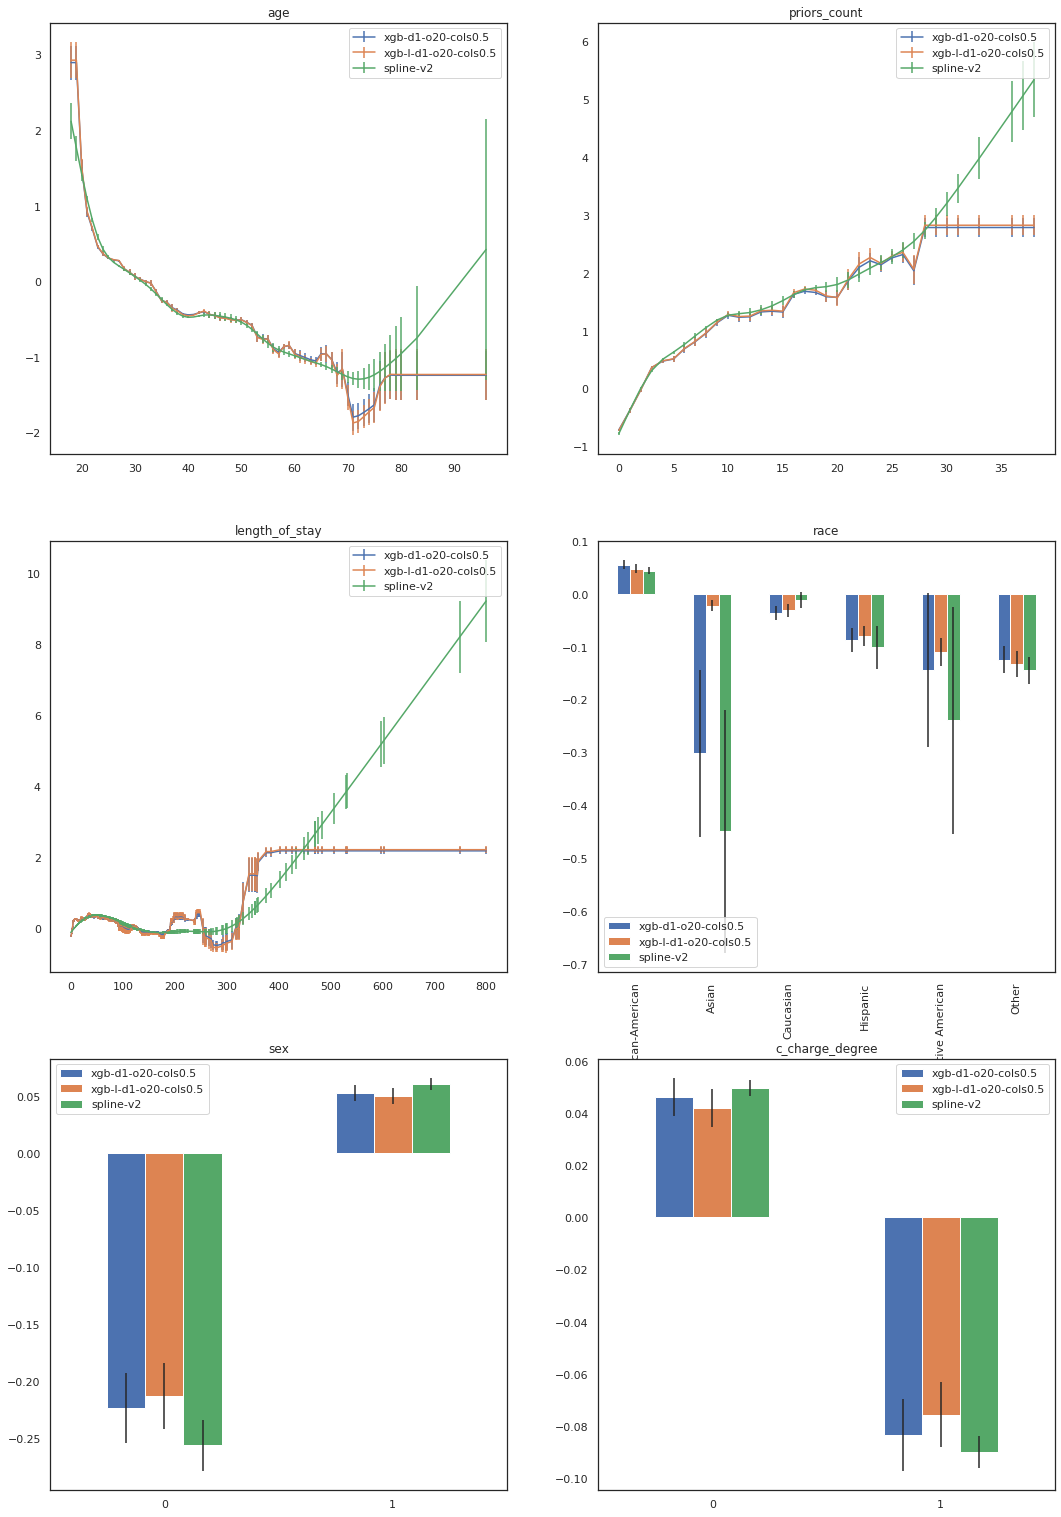

In [15]:
from vis_utils import vis_main_effects
vis_main_effects(all_dfs['compass'], model_names=['xgb-d1-o20-cols0.5', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)

### Encoding bias

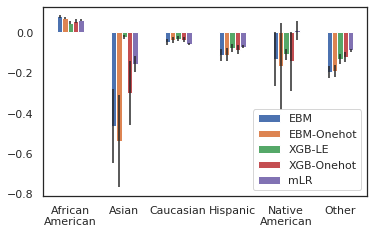

In [39]:
# fig, axes = vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
feature_name, fig_feat_name = 'race', 'race'

# feature_name, fig_feat_name = 'age', 'age'
# feature_name, fig_feat_name = 'PFratio', 'pfratio'
# feature_name, fig_feat_name = 'SBP', 'sbp'
# feature_name, fig_feat_name = 'AIDS', 'aids'


fig, axes = vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-h-o50-i50-q', 'xgb-l-d1-o20-cols0.5', 'xgb-d1-o20-cols0.5', 'mlr-q'],
                             call_backs=None, num_cols=1, feature_names=[feature_name], figsize=(5.8, 3.48))

axes.legend(['EBM', 'EBM-Onehot', 'XGB-LE', 'XGB-Onehot', 'mLR'], fontsize=11)
axes.set_ylabel('')
axes.set_title('')

labels = ['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
axes.set_xticklabels(labels)

# axes.set_xticks([1, 2, 3, 4, 5, 6], ['African \\ American', '', '', '', '', ''])
for tick in axes.get_xticklabels():
    tick.set_rotation(0)

In [40]:
fig.savefig('./notebooks/figures/encoding_ebm_xgb_%s.pdf' % fig_feat_name, bbox_inches='tight', dpi=300)

### Figure 1

In [17]:
import seaborn as sns
sns.set(style="white")

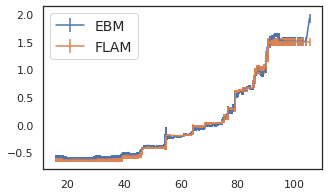

In [31]:
from vis_utils import vis_main_effects
# fig, axes = vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
# feature_name, fig_feat_name = 'race', 'race'

feature_name, fig_feat_name = 'Age', 'age'
# feature_name, fig_feat_name = 'PFratio', 'pfratio'
# feature_name, fig_feat_name = 'SBP', 'sbp'
# feature_name, fig_feat_name = 'AIDS', 'aids'


fig, axes = vis_main_effects(all_dfs['mimicii'], model_names=['ebm-o100-i100-q', 'flam'],
                             call_backs=None, num_cols=1, feature_names=[feature_name], figsize=(5, 3))

axes.legend(['EBM', 'FLAM'], fontsize=14)
axes.set_ylabel('')
axes.set_title('')
# axes.set_xticklabels([0, 1])

for tick in axes.get_xticklabels():
    tick.set_rotation(0)

In [32]:
fig.savefig('./notebooks/figures/fig1_%s_flam.pdf' % fig_feat_name, bbox_inches='tight', dpi=300)

### Sec. 3.1 case study

Text(0.5, 1.0, '')

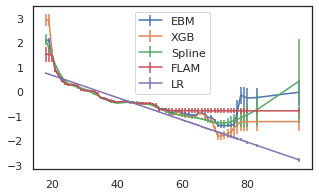

In [65]:
# fig, axes = vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
# feature_name, fig_feat_name = 'race', 'race'

feature_name, fig_feat_name = 'age', 'age'
# feature_name, fig_feat_name = 'priors_count', 'priors_count'
# feature_name, fig_feat_name = 'length_of_stay', 'length_of_stay'
# feature_name, fig_feat_name = 'race', 'race'

fig, axes = vis_main_effects(all_dfs['compass'], model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'spline-v2', 'flam', 'lr'],
                             call_backs=None, num_cols=1, feature_names=[feature_name], 
                             figsize=(5, 3),
#                              figsize=(5.8, 3.48),
                             )

axes.legend(['EBM', 'XGB', 'Spline', 'FLAM', 'LR'], fontsize=11.3)
# axes.legend(['EBM', 'XGB', 'Spline', 'FLAM', 'LR'], fontsize=13.2, loc='lower center')
axes.set_ylabel('')
axes.set_title('')

# labels = ['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other']
# axes.set_xticklabels(labels)

# # axes.set_xticks([1, 2, 3, 4, 5, 6], ['African \\ American', '', '', '', '', ''])
# for tick in axes.get_xticklabels():
#     tick.set_rotation(0)

In [66]:
fig.savefig('./notebooks/figures/story_compass_%s.pdf' % fig_feat_name, bbox_inches='tight', dpi=300)

### Supplementary graph

In [107]:
def vis_main_effects(all_dfs, num_cols=4, model_names=None, only_non_binary=False, call_backs=None, 
                     feature_names=None, figsize=None, removed_feature_names=None, 
                     vertical_margin=2, horizontal_margin=2):
    
    if model_names is None:
        model_names = list(all_dfs.keys())
    else:
        all_dfs = {k: all_dfs[k] for k in model_names}
    
    first_df = all_dfs[next(iter(all_dfs))]
    if only_non_binary:
        first_df = first_df[first_df.x.apply(lambda x: x is not None and len(x) > 2)]
    
    if feature_names is None:
        feature_names = first_df.feat_name.unique()
        feature_names = feature_names[feature_names != 'offset']
    
    if removed_feature_names is not None:
        feature_names = [f for f in feature_names if f not in removed_feature_names]
    
    num_rows = int(np.ceil(len(feature_names) / num_cols))
    if figsize is None:
        figsize = (5 * num_cols + horizontal_margin * (num_cols - 1), 3 * num_rows + vertical_margin * (num_rows-1))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    the_df_lookups = {k: df.set_index('feat_name') for k, df in all_dfs.items()}

    for f_idx, feat_name in enumerate(feature_names):
        the_ax = axes if not isinstance(axes, np.ndarray) else axes.flat[f_idx]
        if isinstance(the_df_lookups[model_names[0]].loc[feat_name].x[0], str):
            # categorical variable
            y_dfs = []
            yerr_dfs = []
            for model_name in model_names:
                lookup = the_df_lookups[model_name]
                y_df = pd.DataFrame(lookup.loc[feat_name].y, index=lookup.loc[feat_name].x, columns=[model_name])
                y_dfs.append(y_df)

                if 'y_std' not in lookup.loc[feat_name]:
                    continue

                yerr_df = pd.DataFrame(lookup.loc[feat_name].y_std, index=lookup.loc[feat_name].x, columns=[model_name])
                yerr_dfs.append(yerr_df)

            y_dfs = pd.concat(y_dfs, axis=1)
            if len(yerr_dfs) > 0:
                yerr_dfs = pd.concat(yerr_dfs, axis=1)
            else:
                yerr_dfs = None
            
            y_dfs.plot.bar(ax=the_ax, yerr=yerr_dfs)
            
            # Rotate back to 0
            for tick in the_ax.get_xticklabels():
                tick.set_rotation(0)

            # if it's a boolean, set the rotation back
#             if len(the_df_lookups[model_names[0]].loc[feat_name].x) == 2:
#                 the_ax.set_xticklabels([0, 1])
#                 for tick in the_ax.get_xticklabels():
#                     tick.set_rotation(0)

            # sns.barplot(x='x', y='y', hue='model_name', data=all_plot_dfs, ax=the_ax)
            # for tick in the_ax.get_xticklabels():
            #     tick.set_rotation(45)
        else:
            for model_name in model_names:
                if model_name not in all_dfs:
                    print('%s not in the all_dfs' % model_name)
                    continue
                
                the_df_lookup = the_df_lookups[model_name]
                
                y_std = 0 if 'y_std' not in the_df_lookup.loc[feat_name] else the_df_lookup.loc[feat_name].y_std

                the_ax.errorbar(the_df_lookup.loc[feat_name].x, the_df_lookup.loc[feat_name].y, y_std, label=model_name)

        the_ax.set_title(feat_name)
        the_ax.legend()
    
        if call_backs is not None and feat_name in call_backs:
            call_backs[feat_name](the_ax)
    
    return fig, axes

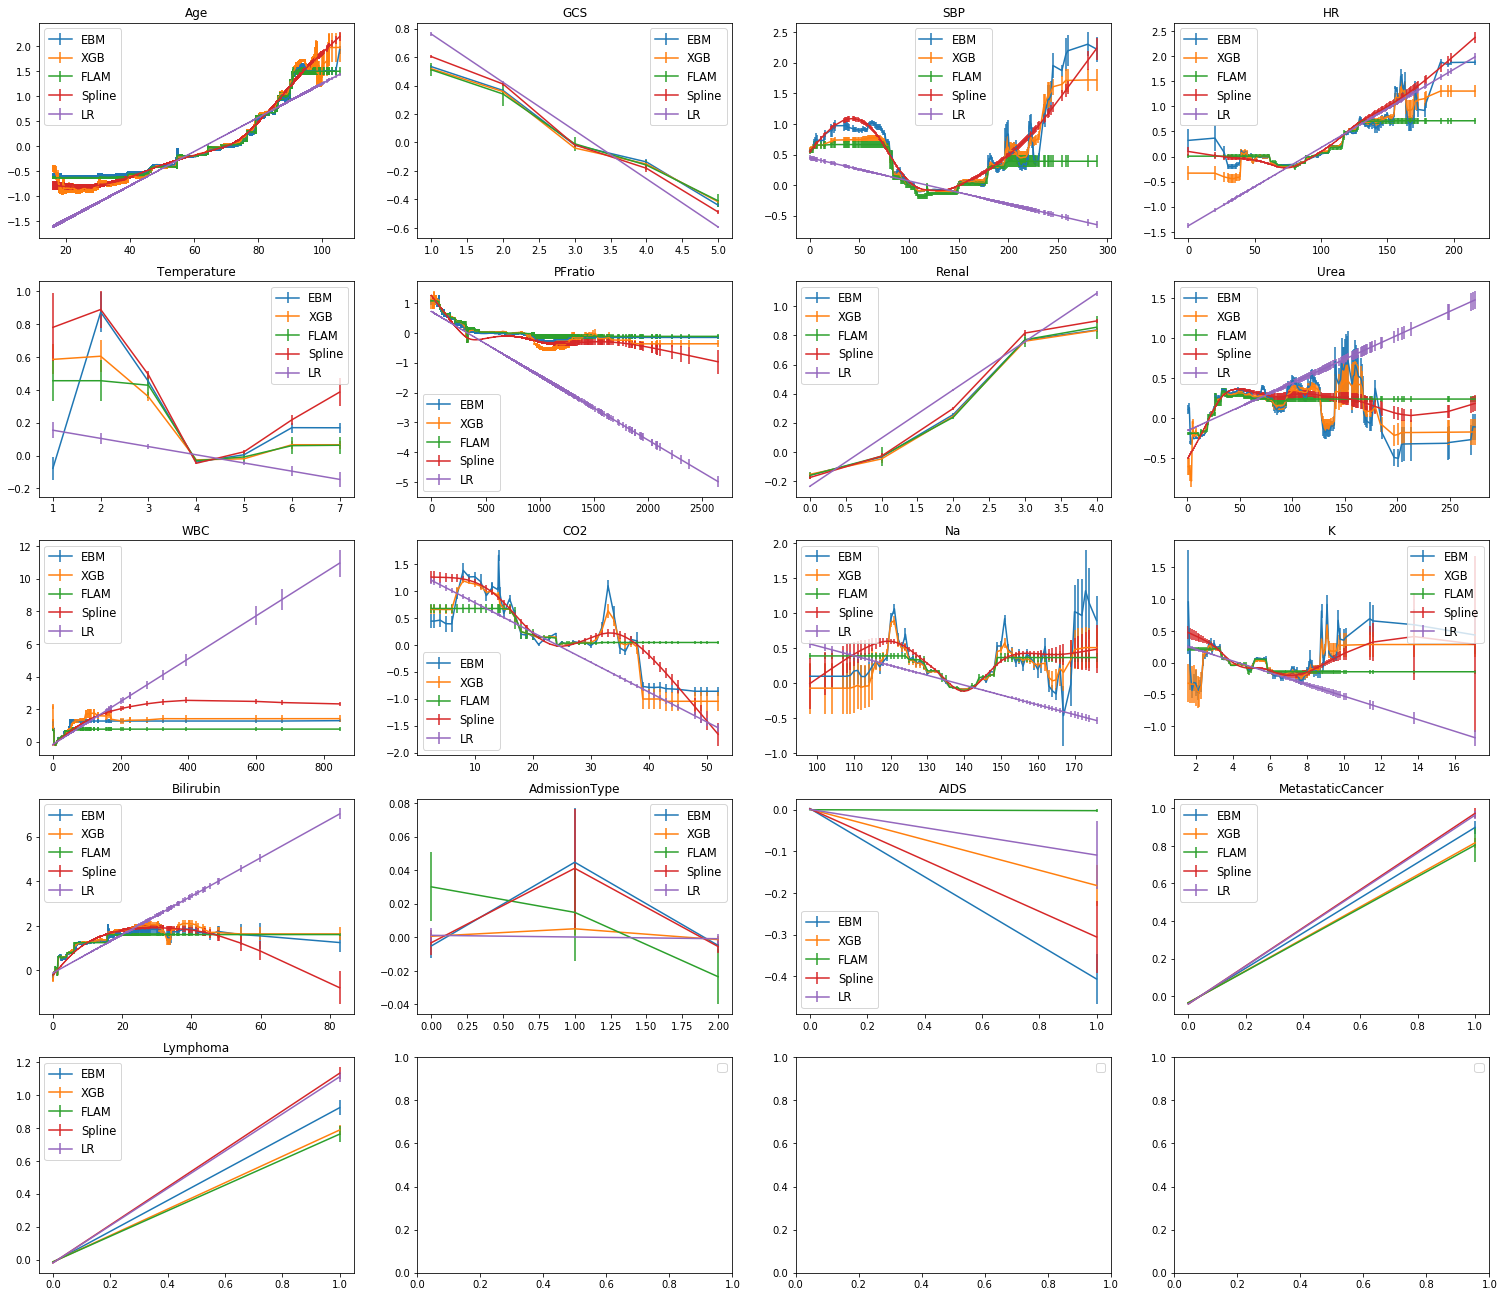

In [108]:
# from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
fig, axes = vis_main_effects(
    all_dfs['mimicii'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4)

for ax in axes.flat:
    ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=11.5)

In [109]:
fig.savefig('./notebooks/figures/mimicii.pdf', bbox_inches='tight', dpi=300)

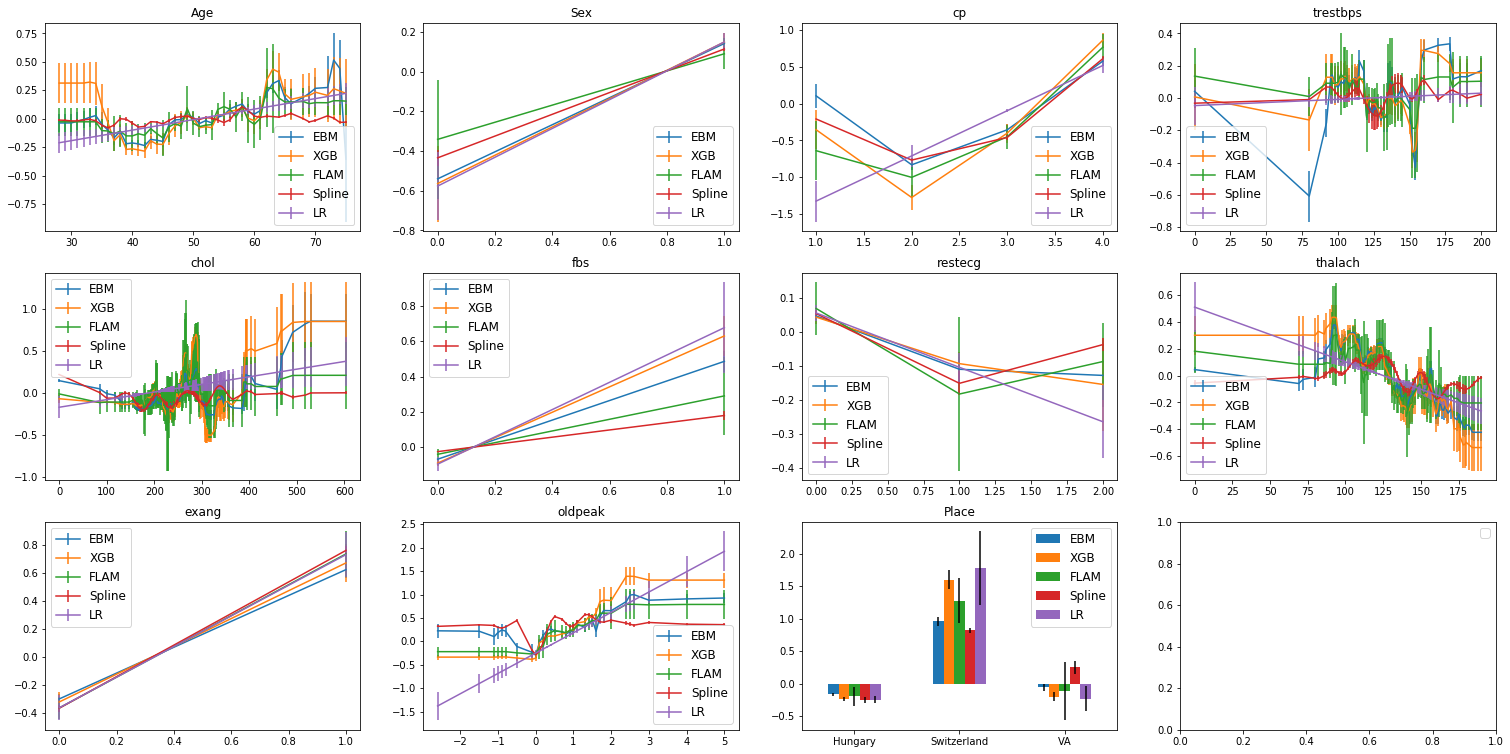

In [110]:
# from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
fig, axes = vis_main_effects(
    all_dfs['heart'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4)

for ax in axes.flat:
    ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12)

for tick in axes.flat[-2].get_xticklabels():
    tick.set_rotation(0)

In [55]:
fig.savefig('./notebooks/figures/heart.pdf', bbox_inches='tight', dpi=300)

In [68]:
all_dfs['churn']['lr'].loc[19].x

['Bank transfer (automatic)',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check']

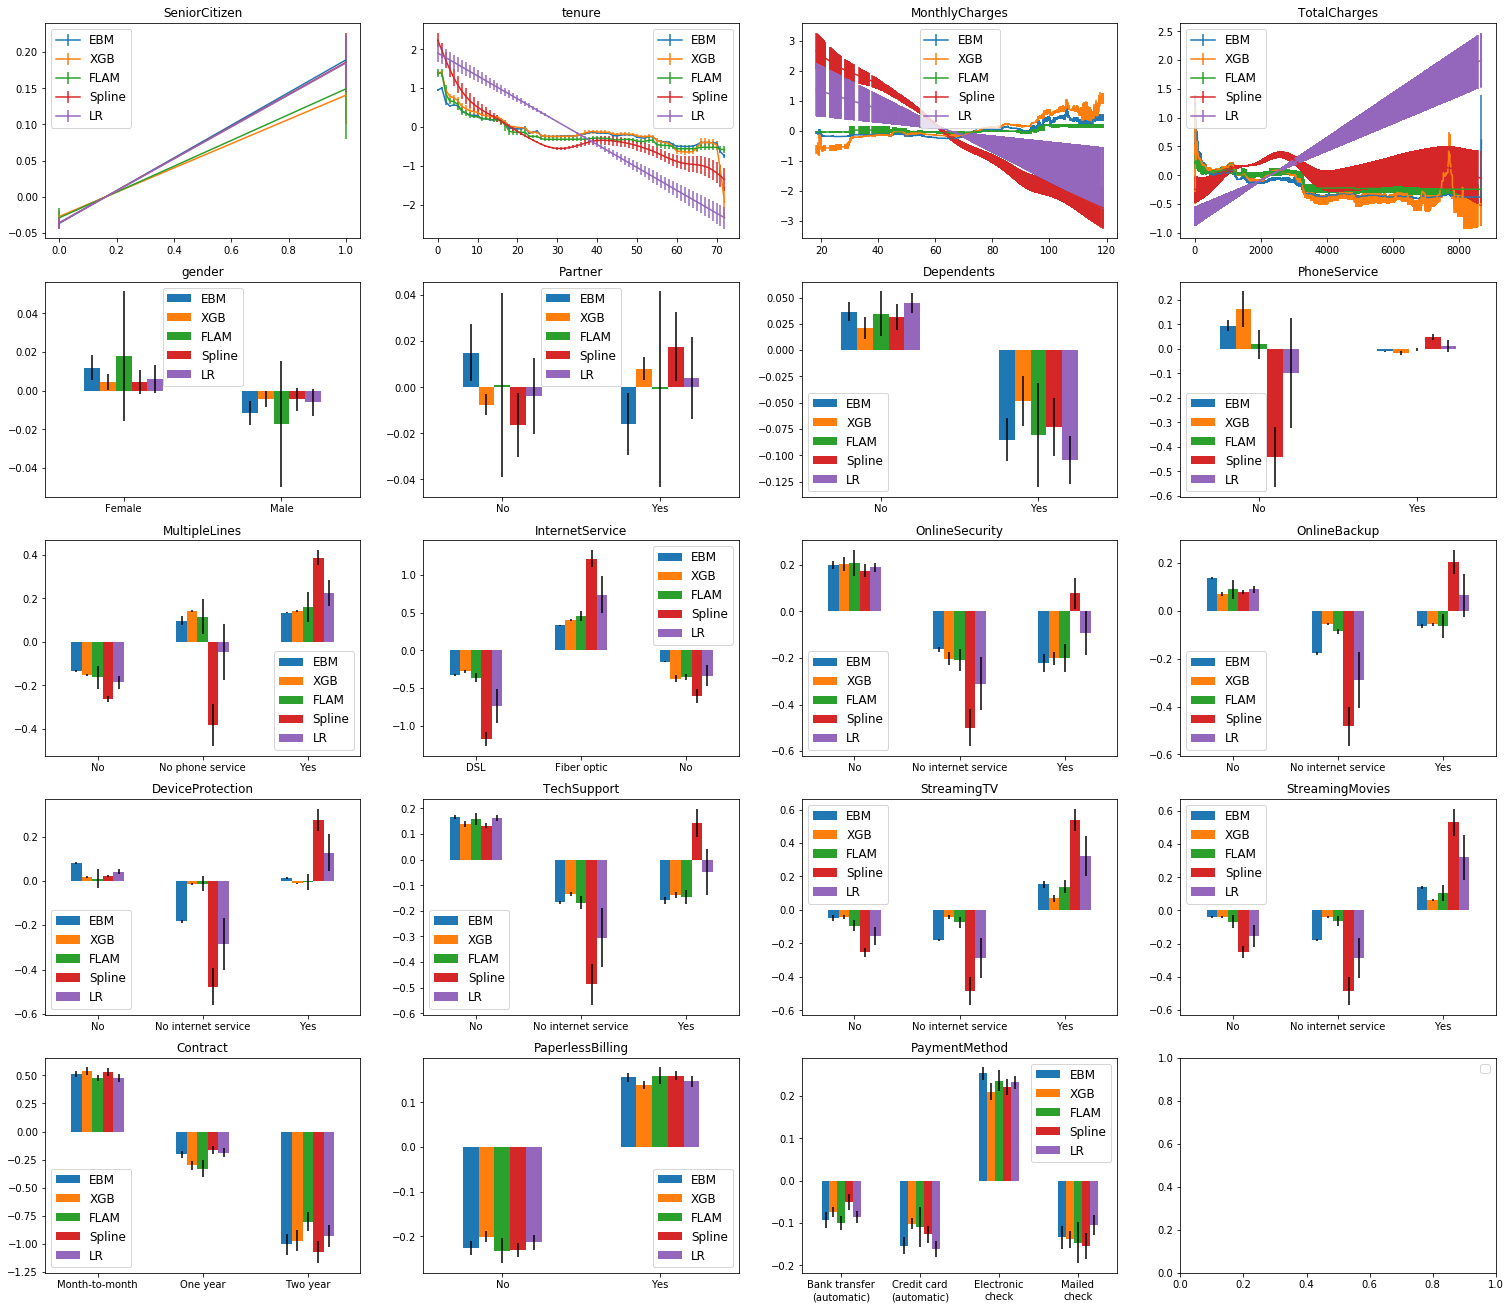

In [74]:
fig, axes = vis_main_effects(
    all_dfs['churn'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4)

names = [
    'Bank transfer\n(automatic)',
    'Credit card\n(automatic)',
    'Electronic\ncheck',
    'Mailed\ncheck',
]

axes.flat[-2].set_xticklabels(names)
for ax in axes.flat:
    if ax in [axes.flat[4], axes.flat[5]]:
        ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12, loc='upper center')
    else:
        ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12)
# for tick in .get_xticklabels():
#     tick.set_rotation(0)

In [75]:
fig.savefig('./notebooks/figures/churn.pdf', bbox_inches='tight', dpi=300)

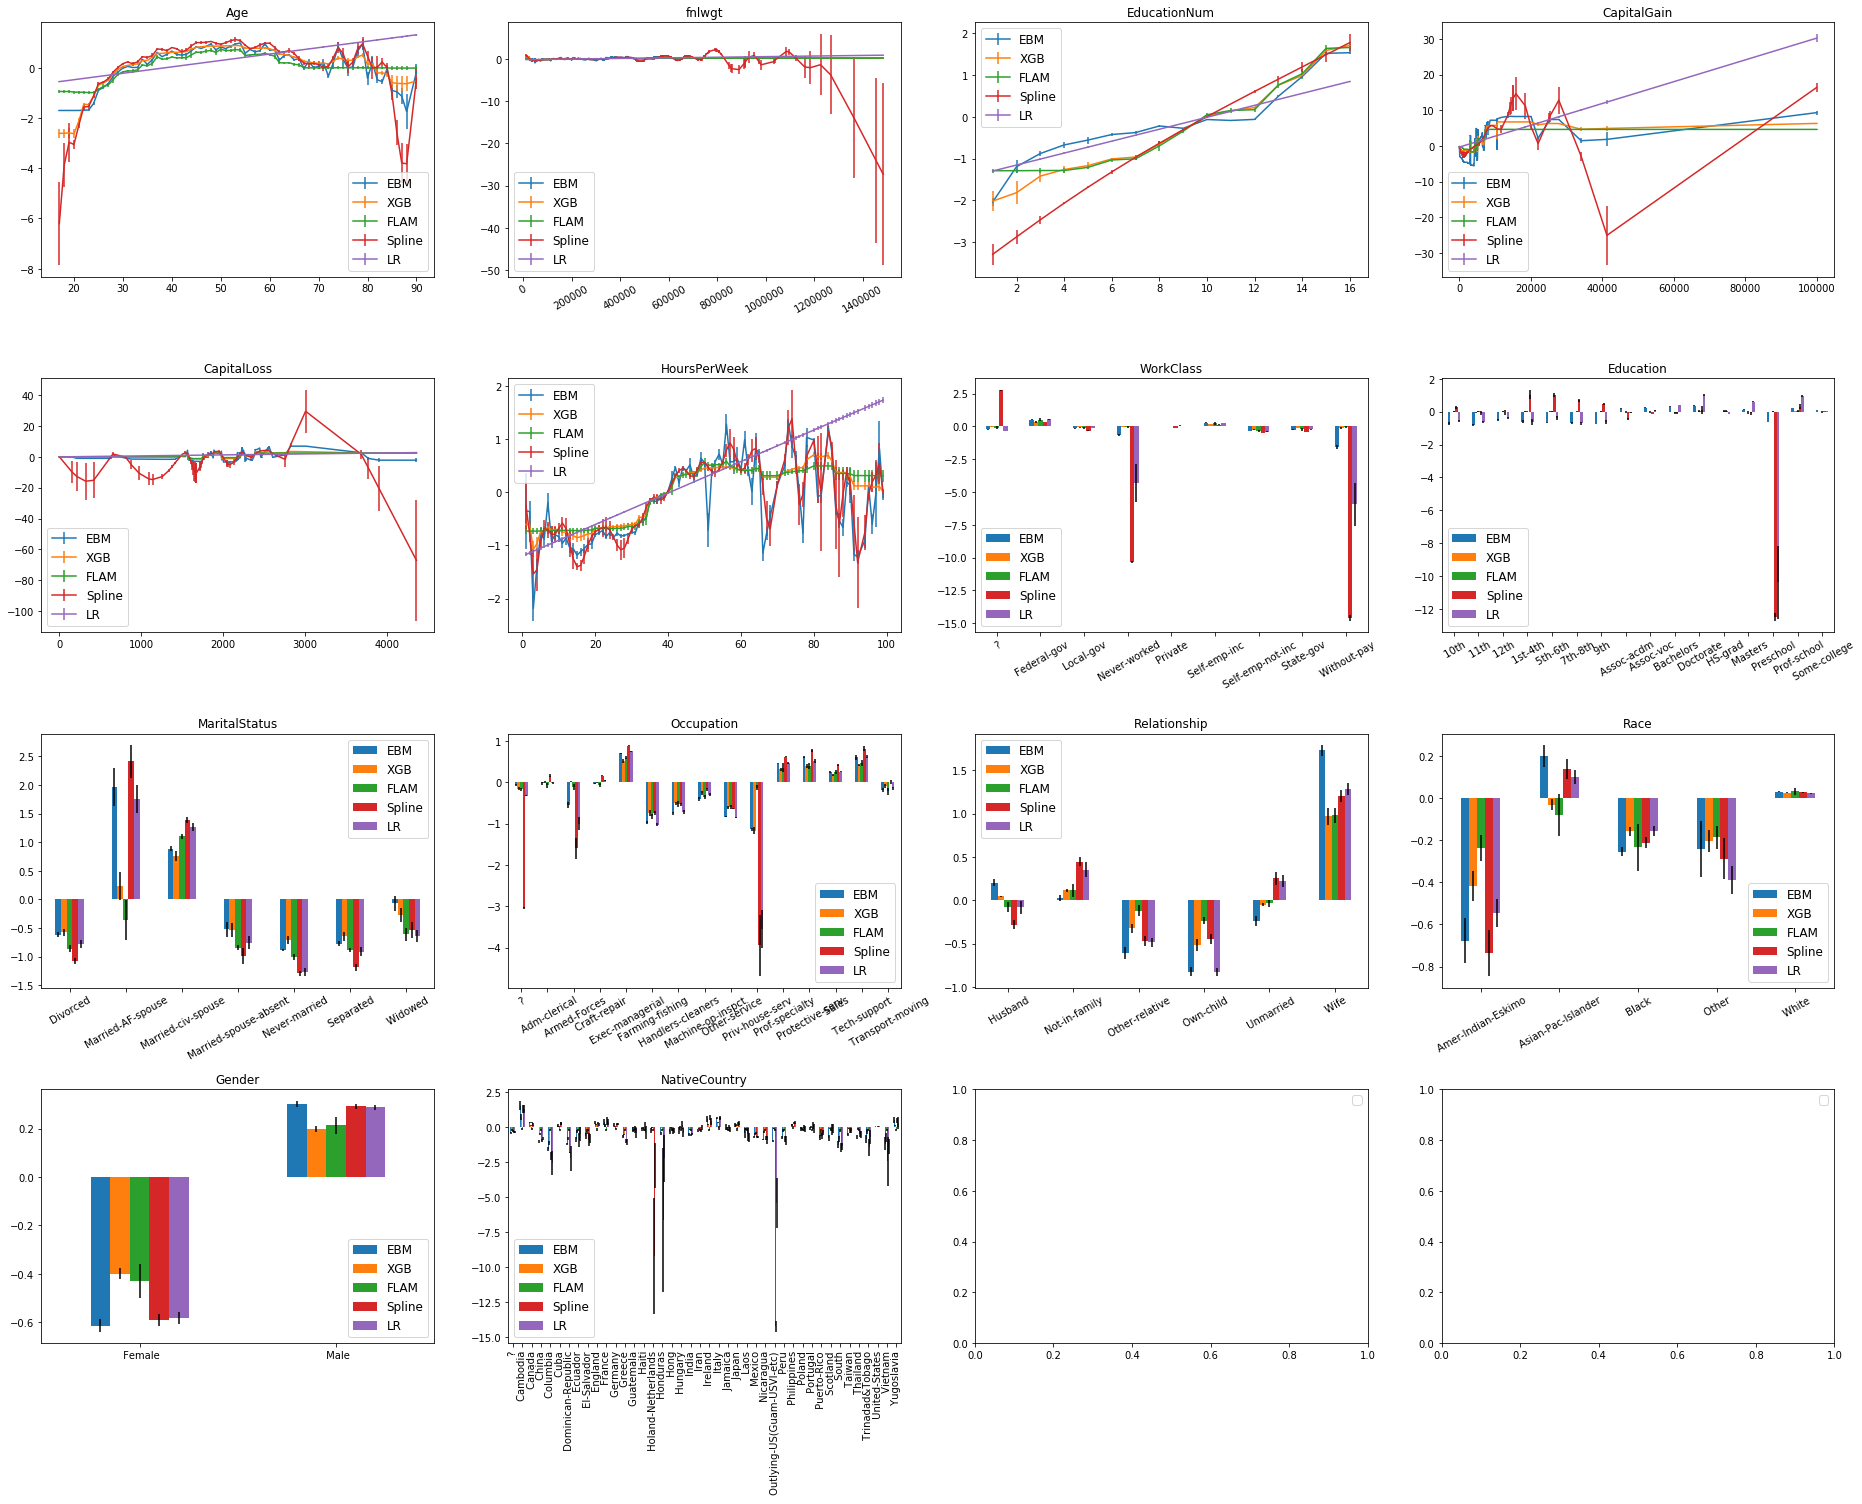

In [115]:
fig, axes = vis_main_effects(
    all_dfs['adult'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4, vertical_margin=3)

for ax in axes.flat:
    ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12)

for ax in [axes.flat[1], axes.flat[6], axes.flat[7], axes.flat[8], axes.flat[9], axes.flat[10], axes.flat[11], axes.flat[13]]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        
for tick in axes.flat[13].get_xticklabels():
    tick.set_rotation(90)
fig.tight_layout()

In [100]:
fig.savefig('./notebooks/figures/adult.pdf', bbox_inches='tight', dpi=300)

In [105]:
all_dfs['breast'].keys()

dict_keys(['ebm-o30-i30', 'ebm-bf-o30-i30', 'ebm-bf-o30', 'xgb-d1-o20', 'skgbt-o20', 'mlr', 'lr', 'ilr', 'ebm-o30', 'spline', 'flam', 'skgbt-d1-o20', 'xgb-d1-o20-cv', 'skgbt-d1-o20-cv', 'ebm-o50-i50', 'lr-o20', 'ebm-bf-o50', 'ebm-bf-o50-i50', 'mlr-o20', 'ilr-o20', 'spline-v2', 'ebm-o50-i50-cv', 'ebm-bf-o50-cv', 'ebm-bf-o50-q', 'ilr-q', 'ebm-o50-i50-q', 'mlr-q', 'rspline', 'spline-b', 'rspline-k10-s', 'rspline-k10', 'rspline-k200', 'rspline-k200-s', 'rspline-v2', 'xgb-d1-o20-cols1', 'xgb-d1-o20-cols0.5', 'xgb-d1-o20-cols0.1', 'xgb-d1-o20-cols0.00001', 'lr-l1', 'rspline-v2-s', 'xgb-d1', 'xgb-d1-o100', 'ebm-o100-i100-q', 'ebm-bf-o100-i100-q', 'xgb-d1-o100-cols0.00001'])

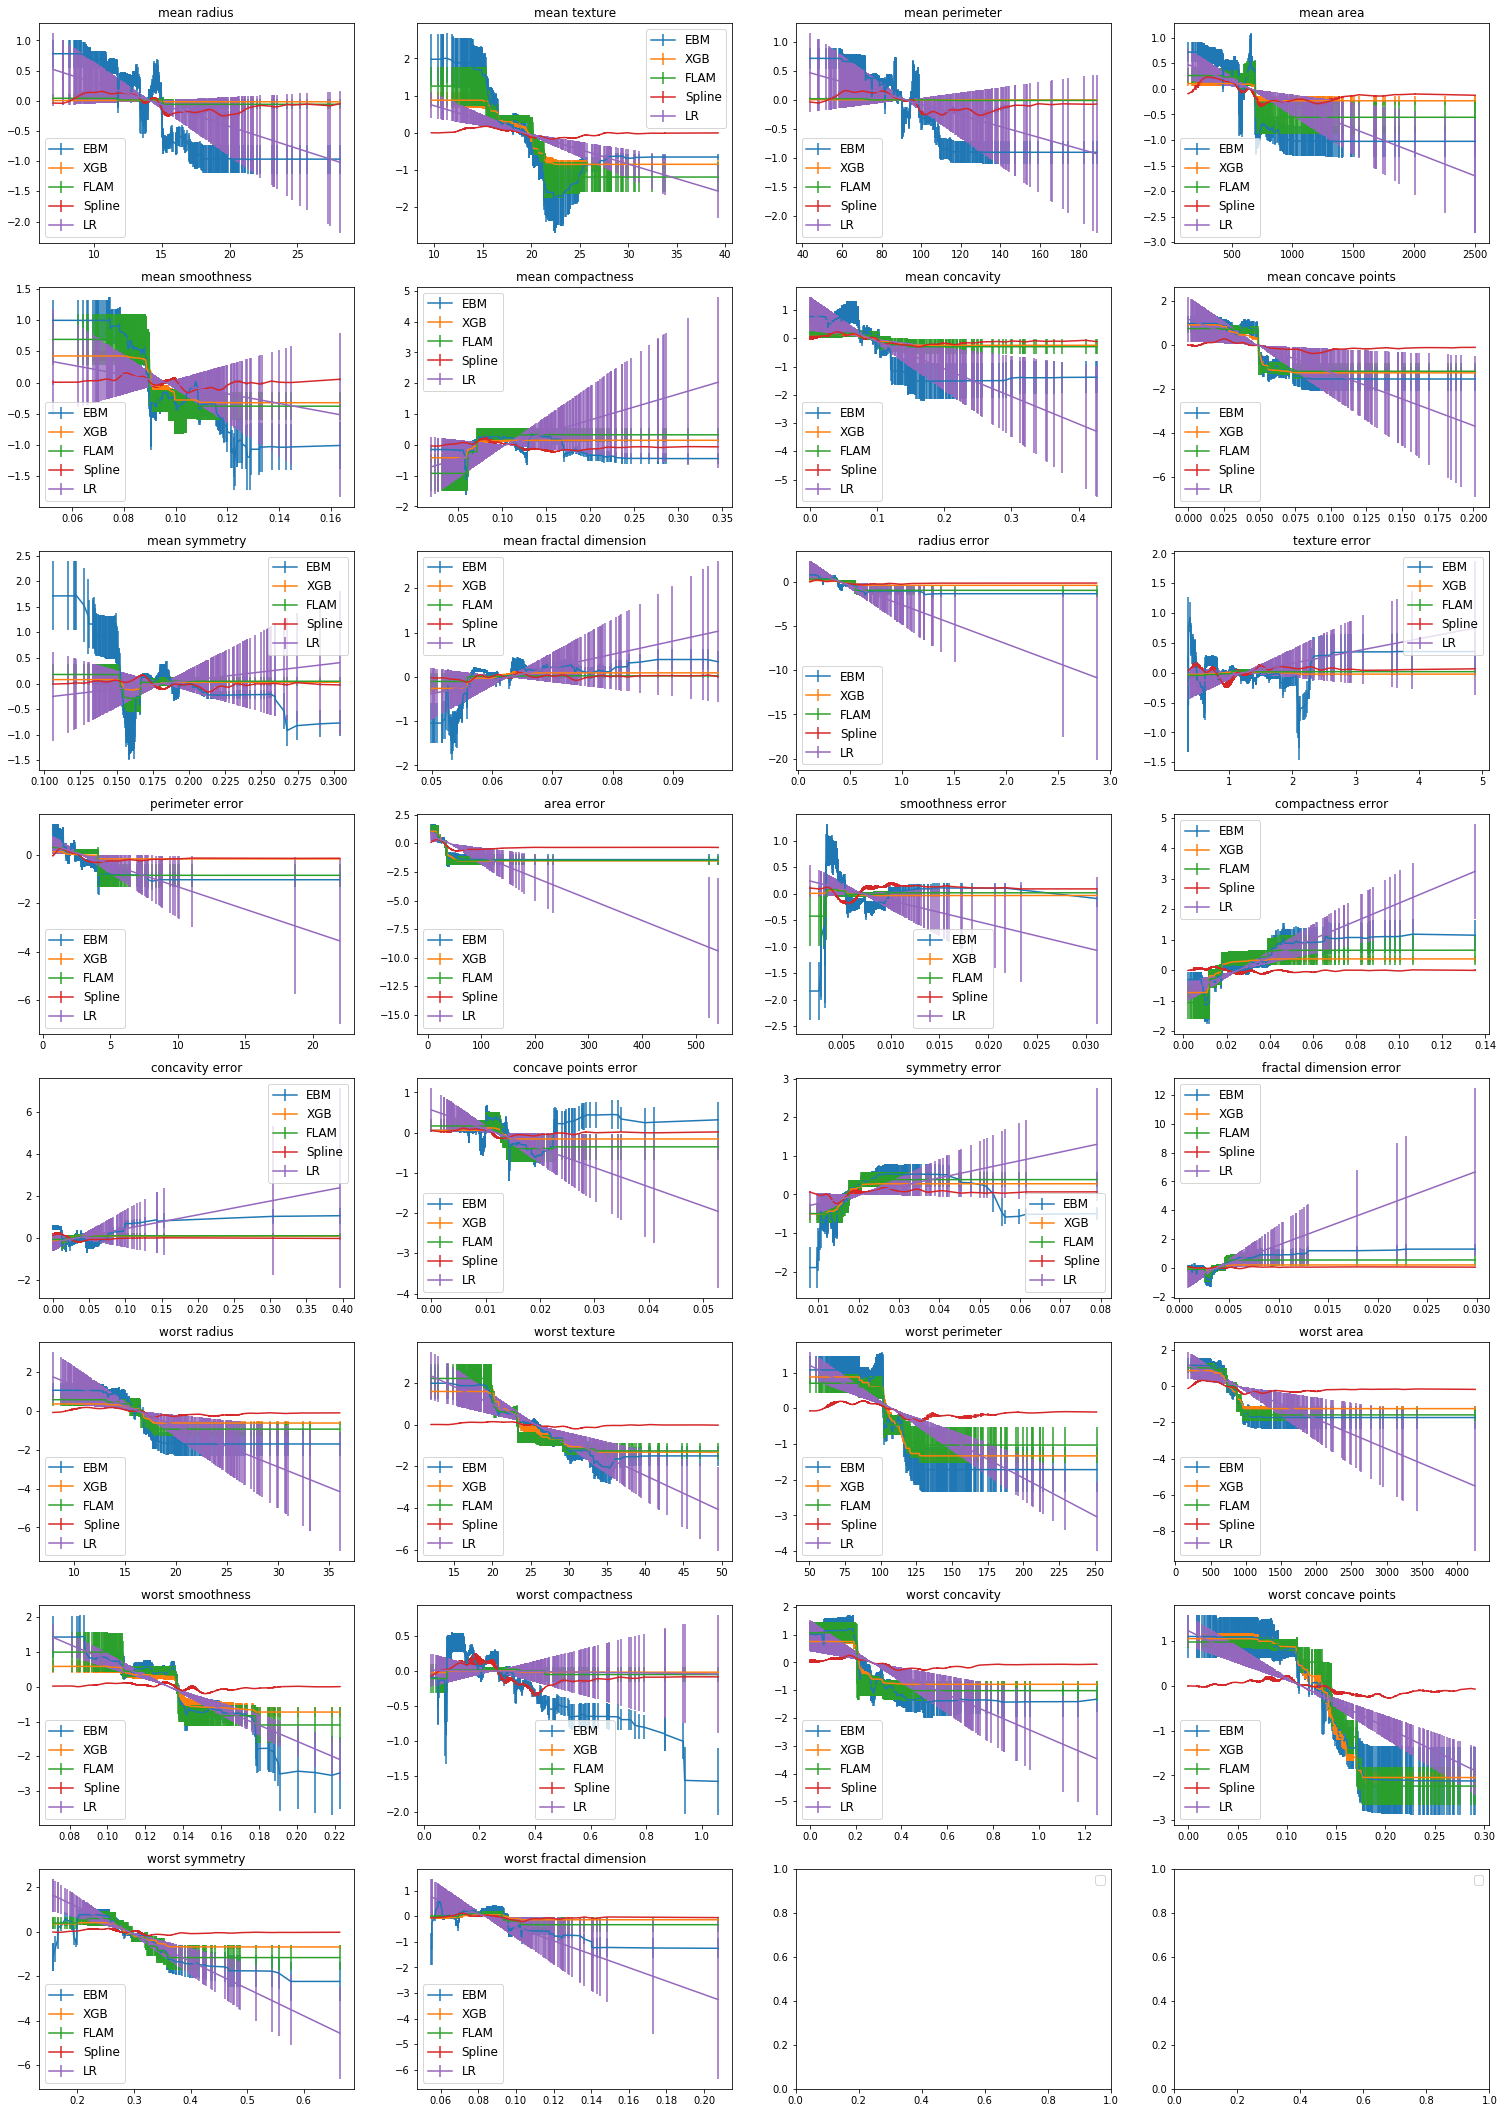

In [116]:
# from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
fig, axes = vis_main_effects(
    all_dfs['breast'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4, horizontal_margin=2, vertical_margin=2)

for ax in axes.flat:
    ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12)

# fig.tight_layout()

In [117]:
fig.savefig('./notebooks/figures/breast.pdf', bbox_inches='tight', dpi=300)

In [121]:
all_dfs['support2cls2'].keys()

dict_keys(['lr', 'flam', 'spline-v2', 'ebm-bf-o50-q', 'ilr-q', 'ebm-o50-i50-q', 'mlr-q', 'xgb-l-d1-o20-cols0.5', 'xgb-d1-o20-cols0.5', 'ebm-h-bf-o50-q', 'ebm-h-o50-i50-q', 'xgb-l-d3-cols0.5', 'xgb-l-d3-o20-cols0.5', 'xgb-l-d1-o20-cols1', 'xgb-d1', 'xgb-d1-o20-cols1', 'ebm-o100-i100-q', 'xgb-d1-o100', 'ebm-bf-o100-i100-q'])

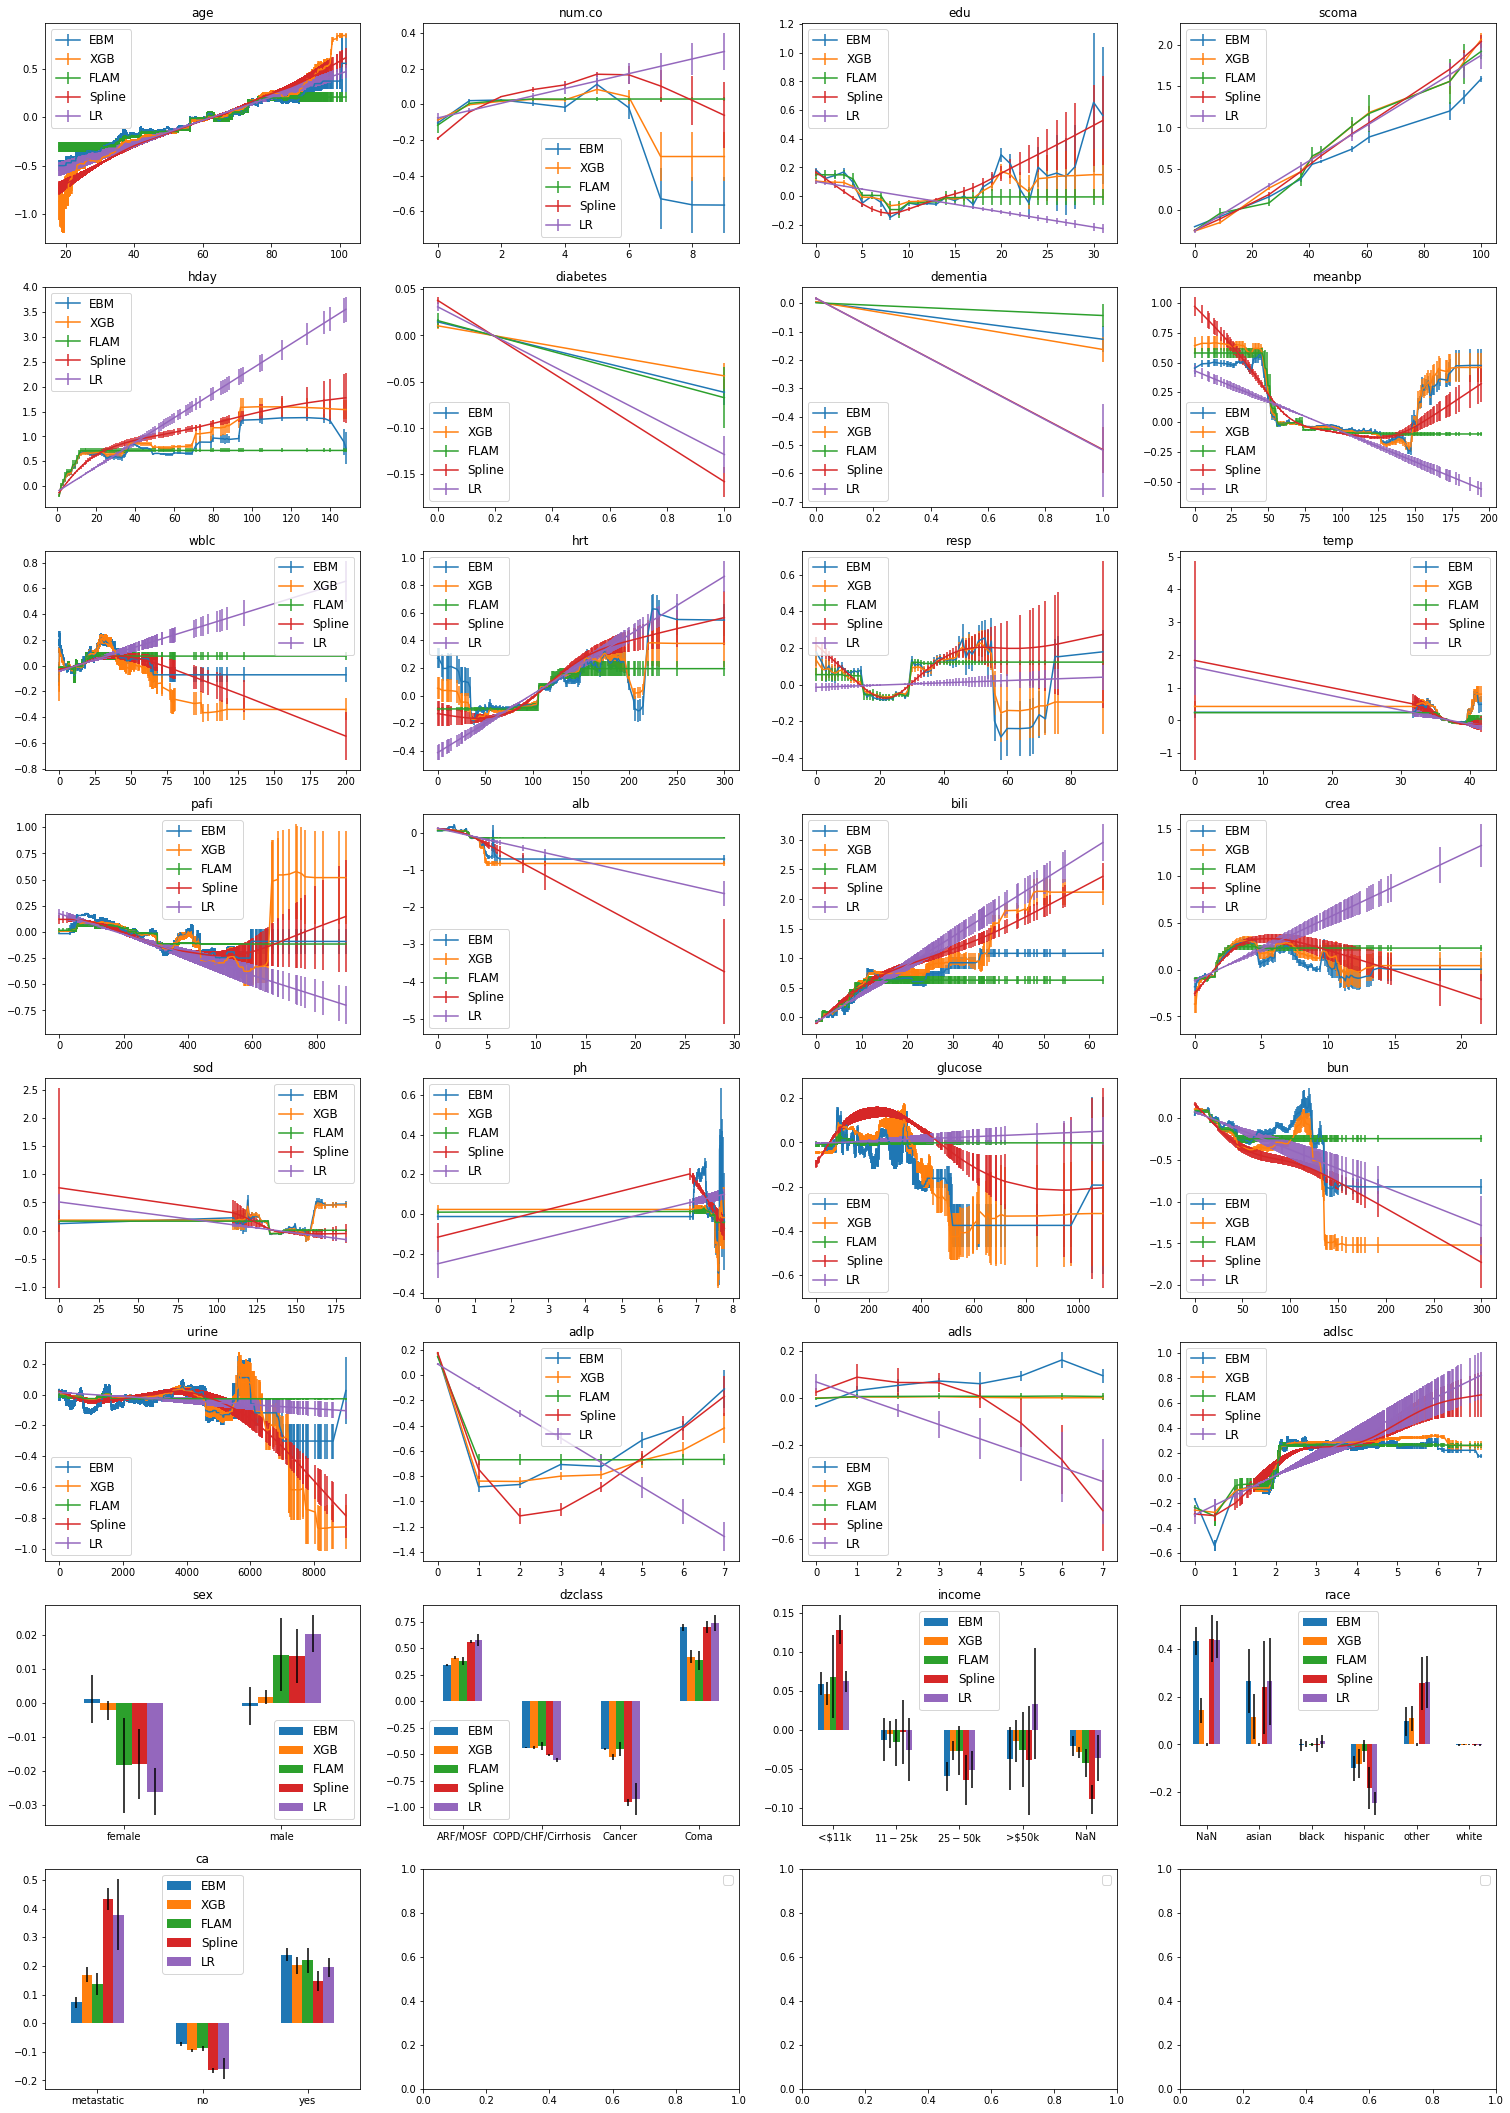

In [122]:
# from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
fig, axes = vis_main_effects(
    all_dfs['support2cls2'], 
    model_names=['ebm-o100-i100-q', 'xgb-d1-o100', 'flam', 'spline-v2', 'lr'], 
    call_backs=None, num_cols=4, horizontal_margin=2, vertical_margin=2)

for ax in axes.flat:
    ax.legend(['EBM', 'XGB', 'FLAM', 'Spline', 'LR'], fontsize=12)

# fig.tight_layout()

In [123]:
fig.savefig('./notebooks/figures/support2cls2.pdf', bbox_inches='tight', dpi=300)

### Old

(<Figure size 1296x1944 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ab0711c90>,
       dtype=object))

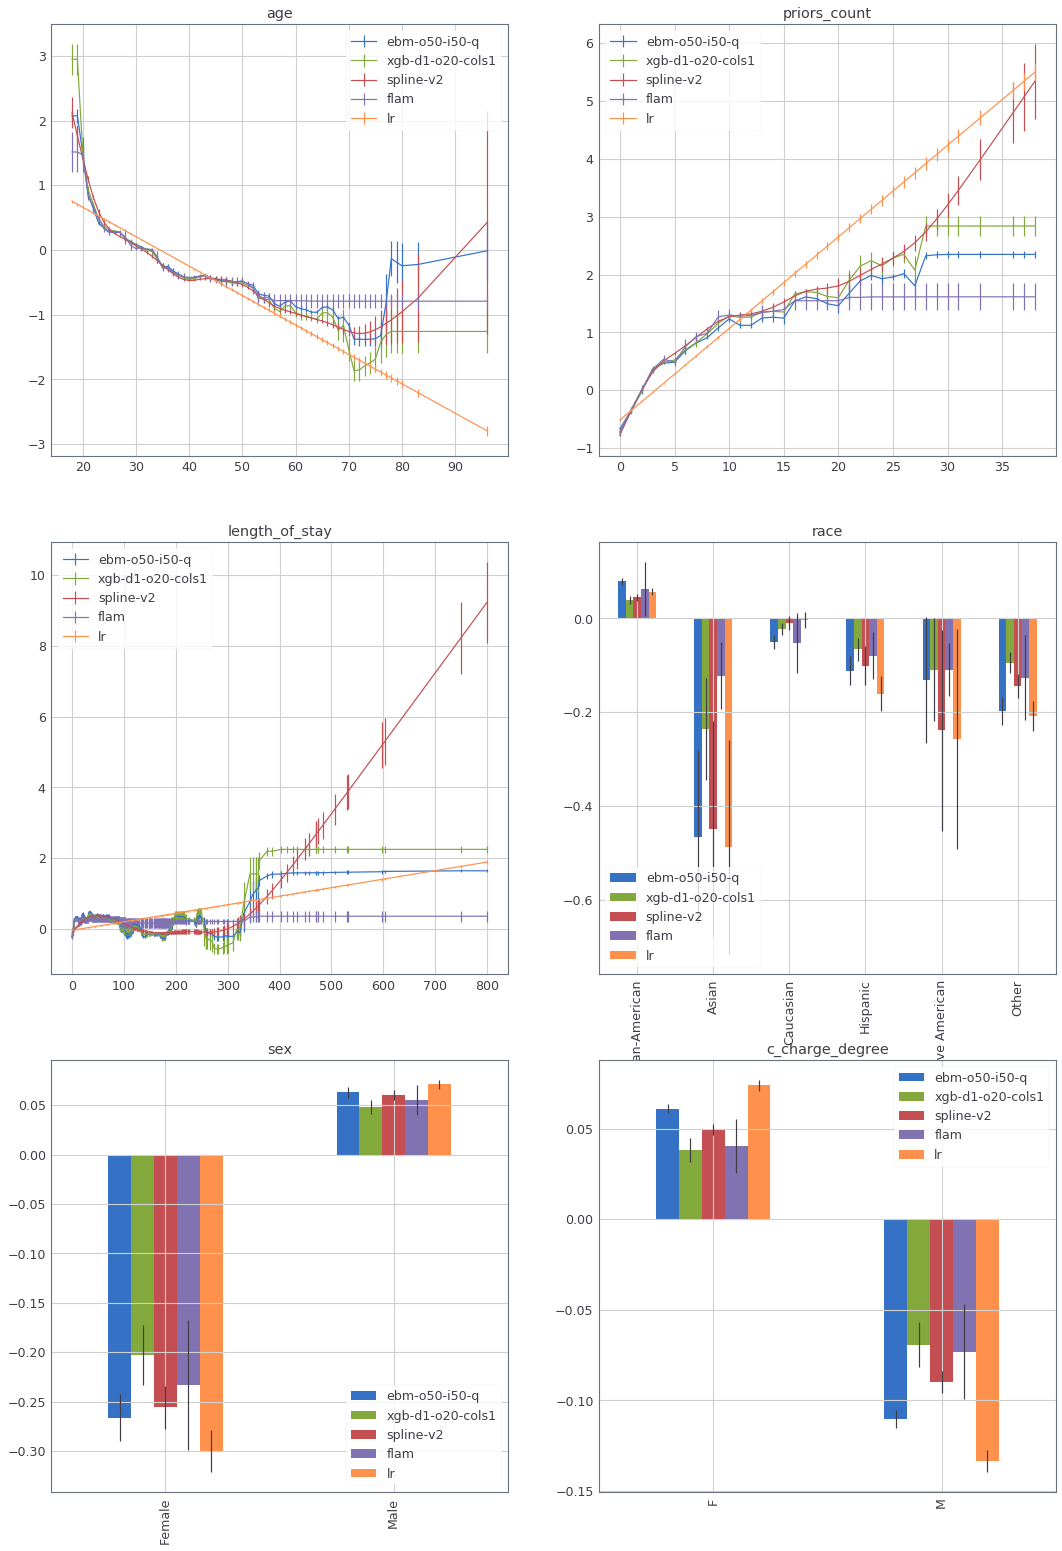

In [16]:
from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'xgb-d1-o20-cols1', 'spline-v2', 'flam', 'lr'], call_backs=None, num_cols=2)

(<Figure size 1296x5832 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f529dae75d0>,
       dtype=object))

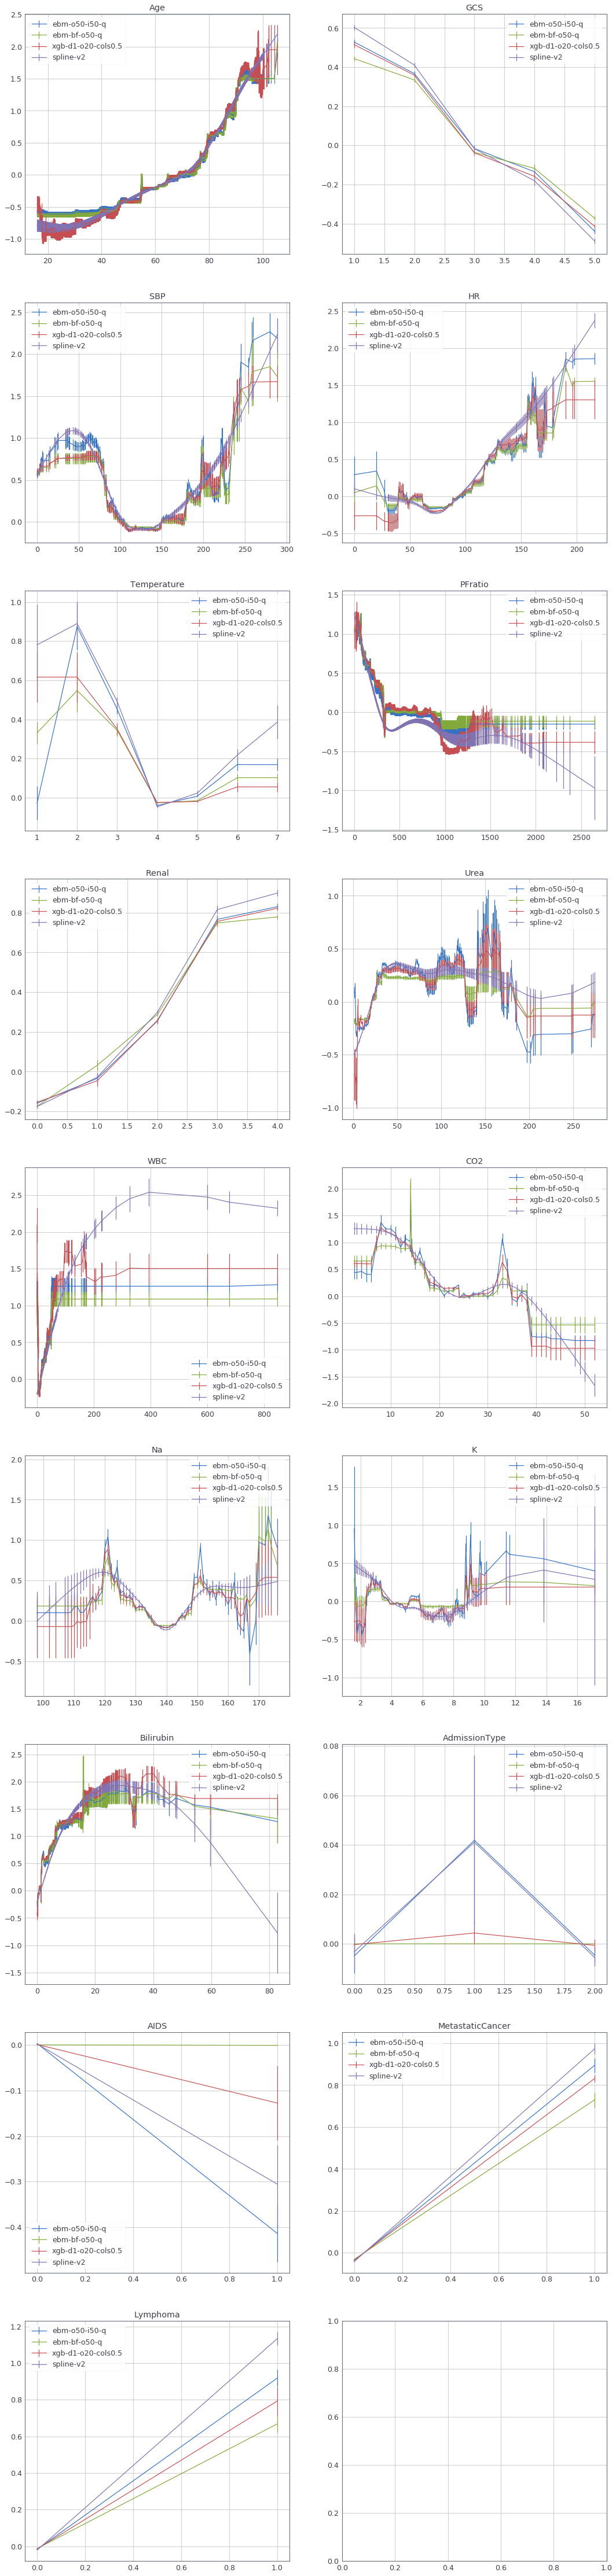

In [12]:
from vis_utils import vis_main_effects
# vis_main_effects(all_dfs['compass'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-l-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)
vis_main_effects(all_dfs['mimicii'], model_names=['ebm-o50-i50-q', 'ebm-bf-o50-q', 'xgb-d1-o20-cols0.5', 'spline-v2'], call_backs=None, num_cols=2)

## Pneumonia

In [ ]:
pneumonia_df = all_record_df[all_record_df.d_name == 'pneumonia']
pneumonia_df.head()

### Performance

In [ ]:
tmp = pneumonia_df.groupby('model_name', as_index=False).agg(['mean', 'std'])[['test_auc', 'test_aupr', 'test_mse', 'train_auc', 'train_aupr', 'train_mse', 'fit_time']]
table = tmp.groupby(level=0, axis=1).apply(lambda x: x.apply(lambda x: '%.3f +- %.3f' % (x[0], x[1]), axis=1))
table.style.apply(highlight_min_max)

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(35, 20))
    
sns.barplot(data=pneumonia_df, x='model_name', y='test_auc', ax=axes.flat[0])    
sns.barplot(data=pneumonia_df, x='model_name', y='test_mse', ax=axes.flat[1])
sns.barplot(data=pneumonia_df, x='model_name', y='test_aupr', ax=axes.flat[2])

sns.barplot(data=pneumonia_df, x='model_name', y='train_auc', ax=axes.flat[3])    
sns.barplot(data=pneumonia_df, x='model_name', y='train_mse', ax=axes.flat[4])
sns.barplot(data=pneumonia_df, x='model_name', y='train_aupr', ax=axes.flat[5])

for ax in axes.flat:
    ax.xaxis.set_tick_params(rotation=45)
plt.show()

### Qualitative analysis

In [ ]:
def vis_main_effects(all_dfs, num_cols = 4, model_names=['ebm-o8', 'skgbt-o8', 'xgb-d1-o8', 'spline', 'ebm-bf-o8', 'spline'], only_non_binary=False, call_backs=None, feature_names=None):
    first_df = all_dfs[next(iter(all_dfs))]
    if only_non_binary:
        first_df = first_df[first_df.x.apply(lambda x: x is not None and len(x) > 2)]
    
    if feature_names is None:
        feature_names = first_df.feat_name.unique()
        feature_names = feature_names[feature_names != 'offset']

    num_rows = int(np.ceil(len(feature_names) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(9 * num_cols, 7 * num_rows))
    
    for model_name in model_names:
        if model_name not in all_dfs:
            print('%s not in the all_dfs' % model_name)
            continue
        
        the_df = all_dfs[model_name]
        the_df_lookup = the_df.set_index('feat_name')
        
        print(model_name)
        for f_idx, feat_name in enumerate(feature_names):
            axes.flat[f_idx].errorbar(the_df_lookup.loc[feat_name].x, the_df_lookup.loc[feat_name].y, the_df_lookup.loc[feat_name].y_std, label=model_name)

            axes.flat[f_idx].set_title(feat_name)
            axes.flat[f_idx].legend()
    
            if call_backs is not None and feat_name in call_backs:
                call_backs[feat_name](axes.flat[f_idx])

#### Linear model comprisons

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['rspline-v2', 'spline-v2'], call_backs=call_backs)

In [ ]:
call_backs = {
    'temperature': lambda ax: ax.set_xlim(30, 45), 
    'pH': lambda ax: ax.set_xlim(6, 8.2), 
}

vis_main_effects(all_dfs['pneumonia'], model_names=['ilr', 'lr', 'mlr', 'ebm-o30-i30'], call_backs=call_backs)

#### Bagging comparison

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['ebm', 'ebm-o8', 'ebm-o30-i30'], call_backs=call_backs)

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-bf', 'ebm-bf-o8', 'ebm-bf-o30-i30'], call_backs=call_backs)

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['xgb-d1', 'xgb-d1-o8', 'xgb-d1-o16'], call_backs=call_backs)

#### ebm vs ebm-bf

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-bf', 'ebm'], call_backs=call_backs)

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['ebm-bf-o8', 'ebm-o16-i16'], call_backs=call_backs)

#### skgbt vs ebm-bf vs xgb

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['skgbt', 'ebm-bf', 'xgb-d1'], call_backs=call_backs)

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['mlr', 'skgbt-o8', 'ebm-bf-o8', 'xgb-d1-o16'], call_backs=call_backs)

#### Best models

In [ ]:
the_dfs = all_dfs['pneumonia']
model_names = ['flam', 'spline', 'ebm-o30-i30', 'ebm-bf-o30', 'skgbt-o20', 'xgb-d1-o20']
# model_names = ['lr', 'ilr', 'mlr', 'ebm-o30-i30']

feat_name = 'BUN_level'
# feat_name = 'age'
# feat_name = 'pO2'
# feat_name = 'history_of_chest_pain'
# feat_name = 'lobe_or_lung_collapse'
# feat_name = 'asthma'

fig, axes = plt.subplots(figsize=(20, 12))
    
for model_name in model_names:
    if model_name not in the_dfs:
        print('%s not in the the_df' % model_name)
        continue

    the_df = the_dfs[model_name]
    the_df_lookup = the_df.set_index('feat_name')

    print(model_name)
    
    axes.errorbar(the_df_lookup.loc[feat_name].x, the_df_lookup.loc[feat_name].y, the_df_lookup.loc[feat_name].y_std, label=model_name)
    axes.set_title(feat_name)
    axes.legend()

# plt.xticks(np.arange(20, 110, 10))
# axes.set_ylim(-2, 2)

In [ ]:
vis_main_effects(all_dfs['pneumonia'], model_names=['flam', 'spline', 'ebm-o50-i50', 'ebm-bf-o50', 'xgb-d1-o20-cv'])